# TRICASTIN EXAMPLE
- loop over days
- loop over different time windows
- for a specific f0 or a freq range

# init packages and define params

In [4]:
import sys,os,glob,time,copy,warnings,cProfile,shutil,matplotlib
from IPython import display
import h5py as h5
import numpy as np
import scipy.fftpack
import scipy.signal
import scipy.io as io
import skimage.restoration as deconv
from math import cos, sin, radians
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
from tqdm import tqdm


import m_beam
import io_beam
import plt_beam
import dd
import lang

from functions import * ###################################### rajouter des fonctions par ex pour calculer la posiiton du barycentre

import ipdb

%matplotlib widget

lon, lat,height            = compute_barycenter(in_['station_file']) #calcule directe les coordonnées du centre avec la fonction
bb['center']               = np.array([lat,lon])
bb['max_radius_selection'] = None #2000 # in meter from the cntral point or None
bb['target_baz']           = None # if any target direction ... like an EQ back az , for plot purpose

from variables import *


#on importe les variables en dernier pour qu'il corrige ce qui doit être corrigé 


# Read station list and check the map
- make selection 
- compute relative positions
- plot

<class 'dict'>
sta         :  dict   {'XN_AHAB_00': {'net': 'XN', 'name': 'AHAB', 'lo
pos         :  numpy.ndarray  [[ -493.46997991  -293.18193911]
 [ 6703.8003704
lat         :  numpy.ndarray  [35.9767   35.978802 35.950901 35.969101 35.9555
lon         :  numpy.ndarray  [-120.544502 -120.464699 -120.547501 -120.5     
list_of_keys:  list[32]  ['XN_AHAB_00', 'XN_ALEX_00', 'XN_BECH_00', 'XN_C
center      :  numpy.ndarray  [  35.97934239 -120.53903056]


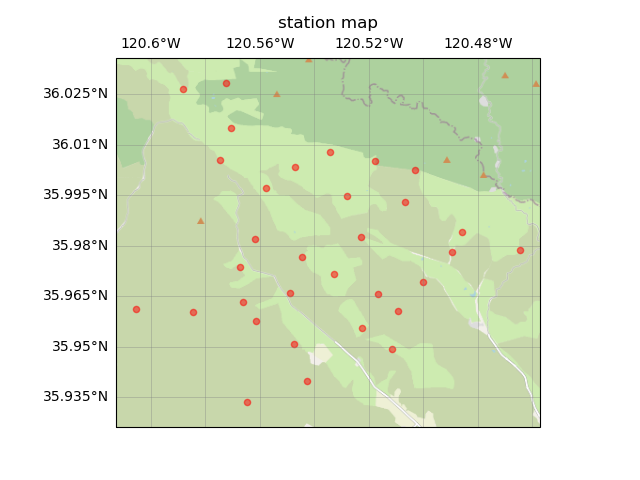

In [5]:
dict_sta = m_beam.manage_station_list(in_,bb)
dd.dd(dict_sta)
plt.close('all')
plt_beam.mmap(111,dict_sta['lon'],dict_sta['lat'],xylabel=True,res=12)


# MAIN LOOPS
- turn time information into sample information
### LOOP 
  - OVER DAYS
    - OVER TIME WINDOWS WITHIN DAYS
        - read data (=> move that in a function ?)
        - select short freq samples
        - compute beam 
        - stack if necessary 
    - save

In [7]:
# N0    = int(tt['t_0']*ff['fs']) #starting sample
# Nw    = int(tt['t_win']*ff['fs']) #number of datapoints for t_win
# Ni    = int(tt['t_inc']*ff['fs']) # increment between 2 consecutives win               
# Ne    = int(tt['t_end']*ff['fs']) # last sample to care about...

# sta          = dict_sta['sta']
# list_of_keys = dict_sta['list_of_keys']



# #loop over days
# ############################### refine file and dir names

# for index_day in tt['day']: # LOOP OVER DAYS

#     in_['full_data_dir']       = in_['data_dir']  + "/data_%d.0"%ff['fs'] + "hz/daily/" + in_['tag'] + "/%04d"%tt['year'] + "/"
#     in_['name_h5']             = "day_%03d.h5"%index_day
#     in_['in_h5']               = in_['full_data_dir']   + "/" + in_['name_h5']

#     N0s = (N0+np.array(range((Ne-N0)//Ni))*Ni).tolist() # list of starting samples accross the day
    
    
#     for inn in N0s:
#         if inn+Nw > Ne:
#             N0s = N0s[0:N0s.index(inn)]
#             break
#         #print(str(inn) + ' - ' + str(inn+Nw+1))

#     for index_N0 in N0s: # LOOP OVER TIME WINDOWS OF A GIVEN DAY
        
#         print(in_['name_h5'] + ' -  component ' + bb['compo'] + ' - time window [' + str(index_N0/ff['fs']) + ' - ' + str((index_N0+Nw)/ff['fs']) + '] s')
        
#         # init data mat
#         if bb['compo'] in ['R','T']:
#             dataE         = np.zeros([Nw,len(sta)])
#             dataN         = np.zeros([Nw,len(sta)])
#         else:
#             data          = np.zeros([Nw,len(sta)])

#         #open h5
#         if not os.path.isfile(in_['in_h5']):
#             raise ValueError("not such file  " + in_['in_h5'])
#         h5f   = h5.File(in_['in_h5'],'r')

#         # loop over stations
#         for kname in sta.keys():
#             locid =  sta[kname]['loc']
#             if locid == '':
#                 locid = '00'
#             if bb['compo'] in ['R','T']:
#                 dataset_nameE= '/'+ sta[kname]['net'] + '/' + sta[kname]['name'] + '.' + locid + '/E'
#                 dataset_nameN= '/'+ sta[kname]['net'] + '/' + sta[kname]['name'] + '.' + locid + '/N'
#                 dataset_name = dataset_nameN
#             else:
#                 dataset_name = '/'+ sta[kname]['net'] + '/' + sta[kname]['name'] + '.' + locid + '/' + bb['compo']
#             try :
#                 if (index_N0+Nw)>=h5f[dataset_name].shape[0]:
#                     if bb['compo'] in ['R','T']:
#                         dataE[0:h5f[dataset_nameE].shape[0],list_of_keys.index(kname)] = h5f[dataset_nameE][index_N0::]
#                         dataN[0:h5f[dataset_nameN].shape[0],list_of_keys.index(kname)] = h5f[dataset_nameN][index_N0::]
#                     else:
#                         data[0:h5f[dataset_name].shape[0],list_of_keys.index(kname)] = h5f[dataset_name][index_N0::]
#                 else:
#                     if bb['compo'] in ['R','T']:
#                         dataE[0:Nw,list_of_keys.index(kname)] = h5f[dataset_nameE][index_N0:index_N0+Nw]
#                         dataN[0:Nw,list_of_keys.index(kname)] = h5f[dataset_nameN][index_N0:index_N0+Nw]
#                     else:
#                         data[0:Nw,list_of_keys.index(kname)] = h5f[dataset_name][index_N0:index_N0+Nw]
#             except:
#                 print("    warning: missing data on this stations : " + kname)
#                 #ipdb.set_trace()
#         h5f.close()
#         sys.stdout.flush()

#         #cn be moved on outside loop
#         if bb['pre_filt']:
#             b,a = scipy.signal.butter(2,(ff['fmin']/ff['fs']/2.,ff['fmax']/ff['fs']/2.),'bandpass',analog=False,output='ba')
#             if bb['compo'] in ['R','T']:
#                 pad = np.tile(scipy.signal.tukey(np.shape(dataE)[0], alpha=0.05),[np.shape(dataE)[1],1]).transpose()
#                 # filter
#                 dataE = scipy.signal.filtfilt(b,a,dataE*pad,axis=0)
#                 dataN = scipy.signal.filtfilt(b,a,dataN*pad,axis=0)
#                 # test norm data :
#                 if bb['clip']:
#                     dataE = np.clip(dataE, -bb['clip']*np.std(dataE),+bb['clip']*np.std(dataE))
#                     dataN = np.clip(dataN, -bb['clip']*np.std(dataN),+bb['clip']*np.std(dataN))
#             else:
#                 pad = np.tile(scipy.signal.tukey(np.shape(data)[0], alpha=0.05),[np.shape(data)[1],1]).transpose()
#                 data = scipy.signal.filtfilt(b,a,data*pad,axis=0)
#                 if bb['clip']:    
#                     data = np.clip(data, -bb['clip']*np.std(data),+bb['clip']*np.std(data))
#     # PLOT DATA ?
#         #plt.close('all')
#         #if bb['compo'] in ['R','T']:
#         #    ax = plt.subplot(121)
#         #    ax.matshow(dataE,aspect='auto')
#         #    ax = plt.subplot(122)
#         #    ax.matshow(dataN,aspect='auto')
#         #else:
#         #    ax = plt.subplot()
#         #    ax.matshow(data,aspect='auto')
#         #fig = plt.gcf()
#         #display.clear_output(wait=True)
#         #display.display(fig)
#         #wait = input("PRESS ENTER TO CONTINUE.")
#         #plt.close()
            

#         # apply fft and define freq vect
#         if bb['compo'] in ['R','T']:
#             freq  = scipy.fftpack.fftfreq(dataE.shape[0], 1/ff['fs'])
#             dataE = scipy.fftpack.fft(dataE,axis=0, overwrite_x=True)
#             dataN = scipy.fftpack.fft(dataN,axis=0, overwrite_x=True)
#         else:
#             freq  = scipy.fftpack.fftfreq(data.shape[0], 1/ff['fs'])
#             data  = scipy.fftpack.fft(data,axis=0, overwrite_x=True)

#         if ff['freq_opt'] == 'central':
#             ifreq = m_beam.make_short_freq(ff['f0'],freq,ff['fw'],ff['nf'])    
#             #print('    f0=' + str(ff['f0']))
#             sys.stdout.flush()
#         elif ff['freq_opt'] == 'minmax':
#             ifreq = m_beam.make_short_freq_range(ff['fmin'],ff['fmax'],freq,ff['nf'])
#             #print('    fmin=' + str(ff['fmin']) + ' - fmax=' + str(ff['fmax']))
#             sys.stdout.flush()       
#         elif ff['freq_opt'] == 'all':
#             ifreq = m_beam.make_short_freq_range(0,ff['fs']/2,freq,ff['nf'])
#         else:
#             print('check freq_opt... default to "all"')
#             ifreq = range(len(freq))
        
#         # resample freq axis
#         if np.isscalar(ifreq):ifreq=[ifreq]
#         ff['sfreq'] = freq[ifreq]

#         #init fk and arf   
#         fk  = np.zeros([len(ifreq),len(bb['U']),len(bb['U'])],dtype=np.complex128)
        
#         # compute beam
#         if bb['compo'] in ['R','T']:
#             fk_tmp,arf = m_beam.beam_H(dataE[ifreq,:],dataN[ifreq,:],ff['sfreq'],bb['U'],dict_sta['pos'],
#                                 u0=np.matrix([0.,0.])*10**-3,output_compo=bb['compo'],fktype=bb['beam_type'])
#         else:
#             fk_tmp,arf = m_beam.beam(data[ifreq,:],ff['sfreq'],bb['U'],dict_sta['pos'],u0=np.array([-0.,-0.])*10**-3,fktype=bb['beam_type'])

#         if bb['stack_daily']:
#             print('stack ABS(FK) ...')
#             fk = fk + np.abs(fk_tmp /len(N0s))
#         else:      
#             save_dic = {
#             'in_' : in_,
#             'tt'  : tt,
#             'ff'  : ff,
#             'bb'  : bb,
#             'pl'  : pl,
#             'fk'  : fk_tmp,
#             'arf' : arf,
#             'sta' : dict_sta      
#             }
#             time_string = compute_time_string(index_N0,ff['fs'])
#             beam_file = in_['beam_dir'] + '/beam_' + bb['compo'] + '_t0_' + time_string + '_tw_' + "%d"%(tt['t_win']/60) + 'min_' + in_['name_h5']
#             #beam_file = in_['beam_dir'] + '/beam_' + bb['compo'] + '_t0_' + "%02d"%(index_N0/ff['fs']/3600) + 'h_tw_'+ "%d"%(tt['t_win']/60) + 'min_' + in_['name_h5']
#             io_beam.write_h5(beam_file, save_dic)

#     if bb['stack_daily']:
#         save_dic = {
#         'in_' : in_,
#         'tt'  : tt,
#         'ff'  : ff,
#         'bb'  : bb,
#         'pl'  : pl,
#         'fk'  : fk,
#         'arf' : arf,
#         'sta' : dict_sta          
#         }
#         beam_file = in_['beam_dir'] + '/beam_' +  bb['compo'] + '_' + in_['name_h5']
#         io_beam.write_h5(beam_file, save_dic)

# LOAD BEAM RESULT, STACK AND PLOT
- update pl arguments (it overwrite arg that are inside every h5 files...)
- plot a single day, stack or loop over a list of days
- save pdf


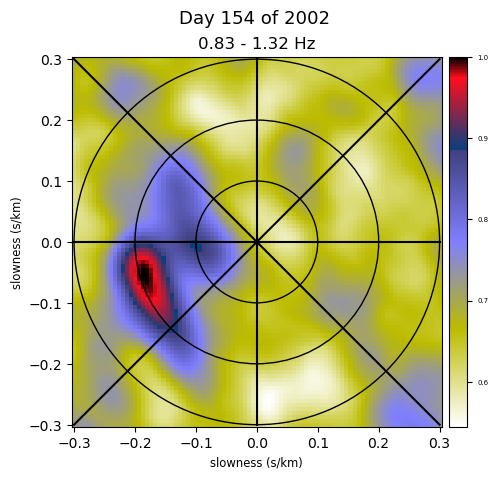

In [7]:
plt.close('all')

tt['day'] = list(range(1,155))
tt['year'] = 2002
plot_day = tt['day']  # 'stack' # int or tt['day'] or 'stack'
ref_day  = 64 # ref day to take 'stack' case. for instance if the array slightly change during the experiment .. use the ARF of this day
num_colu = 1 # number of column in the subplot ...

use_pre_stacked = False # look for any pre-stacked files if True (discarding stacked ones..)
# show_trace = 'AHAB'  # None  pour pas l'afficher 

compo_to_plot   = bb['compo']  #faudra changer la variables dans variables -> important si doit faire plot eq   #'Z'


# manual_lims = [[-69,-59]] #scale db noise
# manual_lims = [[5e-4,1.7e-3]]   #scale noise 
# manual_lims = [[5e-4,0.85e-3]] #scale noise E


# manual_lims = [[0.025,0.4]]  #scale pour eq gonzales en bartlett
# manual_lims = [[0.025,0.45]] #scale pour eq goneales en bartlett  at lwo  frequency


# manual_lims = [[0.025, 0.15]] #simeon 0.67-1.33Hz


# manual_lims = [[0, 1e-4]]
# manual_lims = [[0,0.3]]
# manual_lims = [[1.05e-5,1.15e-5]] #mvdr


manual_lims = [[0,2e-1]]

manual_lims = [[0,4e-6]]

# 0.95   3**(1/2)  #eq gonzales first arrival 
# 0.5  6**(1/2)  #eq gonzales lowfreq 
#1.05  4**(1/6) #noise bonne range  0.8-1.3 
#3**(1/2)   0.5 pour eq_gonzales  0.33-0.67

# 10**1/6  0.95 pour simeon  0.67-1.33 hz 
# 3.**(1/2)  0.4 lowfreq simeon 

pl_updated = {} # plot inputs
pl_updated['fw']                   = 4.**(1/6) # float, from fn[i]/fw to fn[i]*fw , if fw=2**(1/2) (an octave),  if fw=2**(1/6) (1/3 of an octave) # 0= full scale,# 1= monochomatic
pl_updated['fn']                   = [1.05] # list of freq to plot
pl_updated['map']                  = False # plot station map or not ..
pl_updated['clmap']                = 'gist_stern_r' # colormap 
pl_updated['db']                   = False # dB scale ?
pl_updated['norm']                 = True # norm amplitude after freq average for every freq panels
pl_updated['clim']                 = None #manual_lims #None #[0,1e-6]#None #[0,0.00001] # lim colobar, or None for min-max
pl_updated['xy_zoom']              = None #[-0.3,0.3,-0.3,0.3] # xlim ylim
pl_updated['deconv']               = {}
pl_updated['deconv']['apply']      = False # apply deconv - Richardson-Lucy starting from arf?
pl_updated['deconv']['iter']       = 5 #number of iterations
pl_updated['deconv']['sigma']      = 0.01 # apod arf with a Gauss pulse ... to remove edge effect ... decrease sigma if unstable deconv
pl_updated['deconv']['clip']       = False # ..cf richardson_lucy clipping
pl_updated['deconv']['filter_epsilon'] = None # see richardson_lucy
pl_updated['target']               = {'dU':None, 'color':'k'} #delta slowness
pl_updated['save_fig']             = in_['beam_dir'] + '/fig/'
pl_updated['arf_only']             = False # plot only arf instead of fk
pl_updated['power_fk']             = False # power...

###### RAJOUTS POUR PLOT LE POINT CORRESPONDANT À L'ONDE ETUDIÉE
pl_updated['veloc_range']          = (4.2,5.8)
pl_updated['baz_range']            = (210,275)
pl_updated['format']               = 'pdf'


if os.path.isdir(pl_updated['save_fig'])==False :
    os.makedirs(pl_updated['save_fig'])

basename  = '/beam_' +  compo_to_plot
basename2 = in_['beam_dir'] + basename
    
if plot_day == 'stack':
    beam_file_s   = basename2 + '_stack.h5'
    init = True
    for index_day in tt['day']:
        if use_pre_stacked:
            for name in [glob.glob(basename2 + '_t*' + '_day_%03d.h5'%index_day)[index] for index in [0,3,4]]:
                beam_file = name
                print(beam_file)
                h5b   = h5.File(beam_file,'r')
                if init:
                    beam_file_ref = beam_file
                    shutil.copyfile(beam_file_ref,beam_file_s)
                    h5s   = h5.File(beam_file_s,'a')         
                fks   = h5s['fk']       # load the data
                if init:
                    fk  = np.zeros(fks.shape,dtype=np.complex128)
                    init = False
                else:
                    fk = fks[()]
                print('stack ABS(FK) ...')
                fks[...] = fk + np.abs(h5b['fk'][()]/len(tt['day']))
                h5b.close()
        else :
            beam_file = basename2 + '_day_%03d.h5'%index_day
            print(beam_file)
            h5b   = h5.File(beam_file,'r')
            fks   = h5s['fk']       # load the data
            if init:
                fk  = np.zeros(fks.shape,dtype=np.complex128)
                init = False
            else:
                fk = fks[()]
            print('stack ABS(FK) ...')
            fks[...] = fk + np.abs(h5b['fk'][()]/len(tt['day']))
            h5b.close()
    h5s.close()
    plt_beam.make_subfig(beam_file_s,pl_arg=pl_updated,num_colu=num_colu,info=compo_to_plot + '_day_stack')
    fig = plt.gcf()
    fig.savefig(pl_updated['save_fig'] + basename + f"_stack.{pl_updated['format']}",format=pl_updated['format'])
elif isinstance(plot_day,list):
    for iday in plot_day:
        availability_matrix_nobad = np.loadtxt('availability_matrix_nobad')
        idx_availability = installed_days(tt['year'], iday)
        sta_number = np.count_nonzero(availability_matrix_nobad[:,idx_availability]==1)
        #avant d'essayer de plot le beam on doit s'assurer qu'on a de la donnée!!!
        if sta_number >0 and iday!=102:
            if use_pre_stacked: ############################################################################# PRESTACK
                for name in glob.glob(basename2 + '_t*' + '_day_%03d.h5'%iday):
                    beam_file = name
                    baname    = name.split('/')[-1].split('.')[0].split('beam_')[-1]
                    fig = plt.gcf()
                    plt_beam.make_subfig(beam_file,pl_arg=pl_updated,num_colu=num_colu,info=baname,show_trace=show_trace)
                    fig = plt.gcf()
                    if show_trace!=None:
                        fig.text(0.18,0.74,f"Day {iday} of {tt['year']} at {baname[5:-16]}", fontsize=13) #
                    else:
                        fig.text(0.255,0.95,f"Day {iday} of {tt['year']} at {baname[5:-16]}", fontsize=13)  #version qui marche sans trace 
                    fig.savefig(pl_updated['save_fig'] + '/beam_' + baname + f".{pl_updated['format']}" ,format=pl_updated['format'], bbox_inches='tight')
                    display.clear_output(wait=True)
                    display.display(fig)
                    #wait = input("PRESS ENTER TO CONTINUE.")
                    plt.close()
            else:  ############################################################################################# DAILY STACK  
                beam_file = basename2 + f"_{tt['year']}" '_day_%03d.h5'%iday
                fig = plt.gcf()
                plt_beam.make_subfig(beam_file,pl_arg=pl_updated,num_colu=num_colu,info=compo_to_plot + '_day_%03d'%iday)
                fig = plt.gcf()
                fig.text(0.37,0.95,f"Day {iday} of {tt['year']}", fontsize=13)
                fig.savefig(pl_updated['save_fig'] + basename + f"_{tt['year']}_day_%03d.{pl_updated['format']}"%iday,format=pl_updated['format'])
                display.clear_output(wait=True)
                display.display(fig)
                #wait = input("PRESS ENTER TO CONTINUE.")
                plt.close()
else:
    beam_file = basename2 + '_day_%03d.h5'%plot_day
    fig = plt.gcf()
    plt_beam.make_subfig(beam_file,pl_arg=pl_updated,num_colu=num_colu,info=compo_to_plot + '_day_%03d'%plot_day)
    fig = plt.gcf()
    fig.savefig(pl_updated['save_fig'] + basename + f"_day_%03d.{pl_updated['format']}"%plot_day,format=pl_updated['format'])

# Création de la timesrie 

### Création des matrices avec l'évolution de V et BAZ

Folder already created
Processing 2001 data, please wait...


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


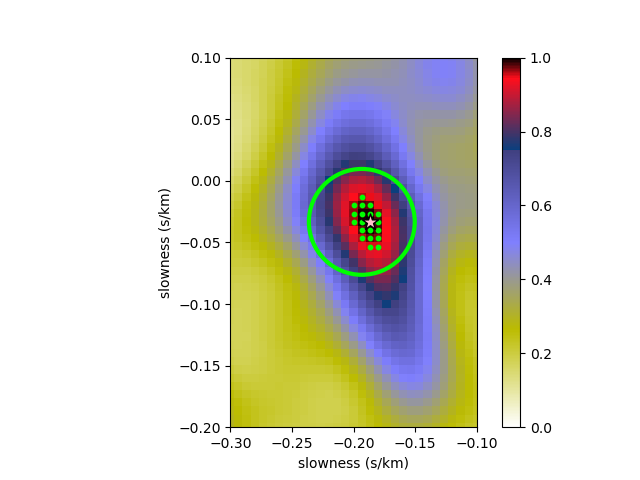

In [29]:
date1 = (2001,10,2)
date2 = (2002,6,4) #on fait l'analyse jusqu'au 4 juin 2002 max (3, car 4 exluded), car après plus assez de stations 

compo_to_plot = 'Z'
pl_updated['fn'] = [1.05]  
pl_updated['fw']                   = 4.**(1/6) #définit la largeur de la fenêtre utilsiée -> utilsier la mêmde gamme que celle utilisée pour les plots pour être consistet
pl_updated['db']                   = False # dB scale ?

################ DECONVOLUTION PLUS DU TOUT DISPO DANS LA FONCTION POUR QU'ELLE SOIT PLUS SIMPLE : FAIRE QUE DU BARTLETT #############
pl_updated['deconv']               = {}
pl_updated['deconv']['apply']      = False # apply deconv - Richardson-Lucy starting from arf?
pl_updated['deconv']['iter']       = 5 #number of iterations
pl_updated['deconv']['sigma']      = 0.01 # apod arf with a Gauss pulse ... to remove edge effect ... decrease sigma if unstable deconv
pl_updated['deconv']['clip']       = True # ..cf richardson_lucy clipping
pl_updated['deconv']['filter_epsilon'] = None # see richardson_lucy

clim = [5e-4,1.7e-3]


dates_range, veloc_matrix, baz_matrix, amplitude_matrix,incert_veloc_matrix, incert_baz_matrix = compute_evolution(date1,date2,
                                                        veloc_range=(4.2,5.8), baz_range=(210,275), plot_blobs=True, clim=clim,
                                                        blend=True)

#MAINTENANT ON EXPORTE TOUT AFIN DE NE PLUS AVOIR À REEXECUTER À CHAQUE FOIS !!! 
# write_utcdatetime_list_to_file('dates_range.txt',date
# write_datetime_list_to_file('dates_range.txt',dates_range)
# np.save('veloc_matrix.npy', veloc_matrix)
# np.save('baz_matrix.npy', baz_matrix)
# np.save('amplitude_matrix.npy', amplitude_matrix)
# np.save('incert_veloc_matrix.npy', incert_veloc_matrix)
# np.save('incert_baz_matrix.npy', incert_baz_matrix)

### Affichage du résultat

perc of amp thresohld = 61.11869491648514
Initial number of dates : 488
Number of dates remaining after applying station threshold: 454 (34 removed)
Initial number of dates before rm_nowave: 454
Number of dates after rm_nowave : 417 (37 removed)
Initial number of dates before applying amplitude threshold : 417
Number of dates after amp_threshold : 310 (107 removed)
Removing listed bad beams... 46 beams to remove in total
Number of dates remaining : 310 (0 removed)
file saved


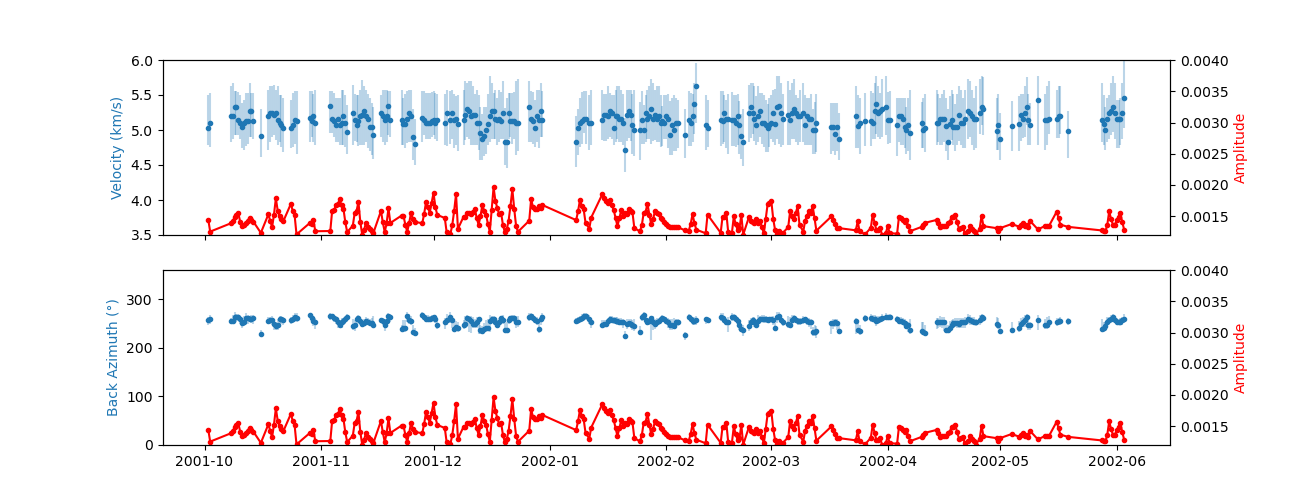

In [6]:
badbeam_list = [datetime(2001,10,6,12),datetime(2001,10,7),datetime(2001,10,7,12),  #jours 279.5, 280 et 280.5
                datetime(2001,10,22,12),datetime(2001,10,23),datetime(2001,10,23,12), #jours atours de 296
                datetime(2001,11,15,12),datetime(2001,11,16),datetime(2001,11,16,12), #jours autour 320
                datetime(2001,11,20,12),datetime(2001,11,21),datetime(2001,11,21,12), #jours autour 325
                datetime(2001,11,26,12),datetime(2001,11,27),datetime(2001,11,27,12), #jours autour 331
                datetime(2001,12,30,12),datetime(2001,12,31), #jour autour de 365
                datetime(2002,2,4,12), datetime(2002,2,5), datetime(2002,2,5,12), # jour 36
                datetime(2002,2,12,12), datetime(2002,2,13), datetime(2002,2,13,12), # jour 44
                datetime(2002,4,13), datetime(2002,4,13,12), # jour 103 et 103.5
                datetime(2002,4,28,12),datetime(2002,4,29),datetime(2002,4,29,12), #jour 119
                datetime(2002,5,1,12),datetime(2002,5,2),datetime(2002,5,2,12),datetime(2002,5,3),datetime(2002,5,3,12), #début mai 
                datetime(2002,5,4,12),datetime(2002,5,5),datetime(2002,5,5,12), #jour 125
                datetime(2002,5,9,12),datetime(2002,5,10),datetime(2002,5,10,12), #jour 130
                datetime(2002,5,23),datetime(2002,5,23,12), #jour 143 et 143.5
                datetime(2002,5,24,12),datetime(2002,5,25),datetime(2002,5,25,12),datetime(2002,5,26),datetime(2002,5,26,12) #fin mai 144.5-146.5
                ]



dates_range = read_datetime_list_from_file('dates_range.txt')
veloc_matrix = np.load('veloc_matrix.npy')
baz_matrix = np.load('baz_matrix.npy')
amplitude_matrix = np.load('amplitude_matrix.npy')
incert_veloc_matrix = np.load('incert_veloc_matrix.npy')
incert_baz_matrix = np.load('incert_baz_matrix.npy')

#calcul du pourcentage associé au threshold qu'on use :
perc = 100*(0.0012/np.max(amplitude_matrix[0,:]))
print('perc of amp thresohld =',perc)

dates_range_clean, veloc_clean, baz_clean, amplitude_clean = plot_evolution(dates_range=dates_range, veloc_matrix=veloc_matrix,
                                                                baz_matrix=baz_matrix,amplitude_matrix=amplitude_matrix,
                                                                incert_veloc_matrix=incert_veloc_matrix,incert_baz_matrix=incert_baz_matrix,
                                                                freqs_to_plot=[1.05], threshold_sta=20, rm_nowave=True,
                                                                figname='parkfield_bartlett_cooked_v3_0.8-1.3Hz_blended_blob_findpeaks_threshold=0.0012.pdf',
                                                                show_amplitude=True, rm_badbeams=badbeam_list, amp_threshold=0.0012,
                                                                show_baz_incert=True,show_veloc_incert=True) 
          
#

# Mainteant que l'on voit la variation de V et de BAZ en fonction du temps, on cherche une rolling median/average de permettant de corriger cette oscillation

On va devoir commencer par rééchantilloner pour avoir 1 mesure par jour (intepolation nécessaire ) 

489


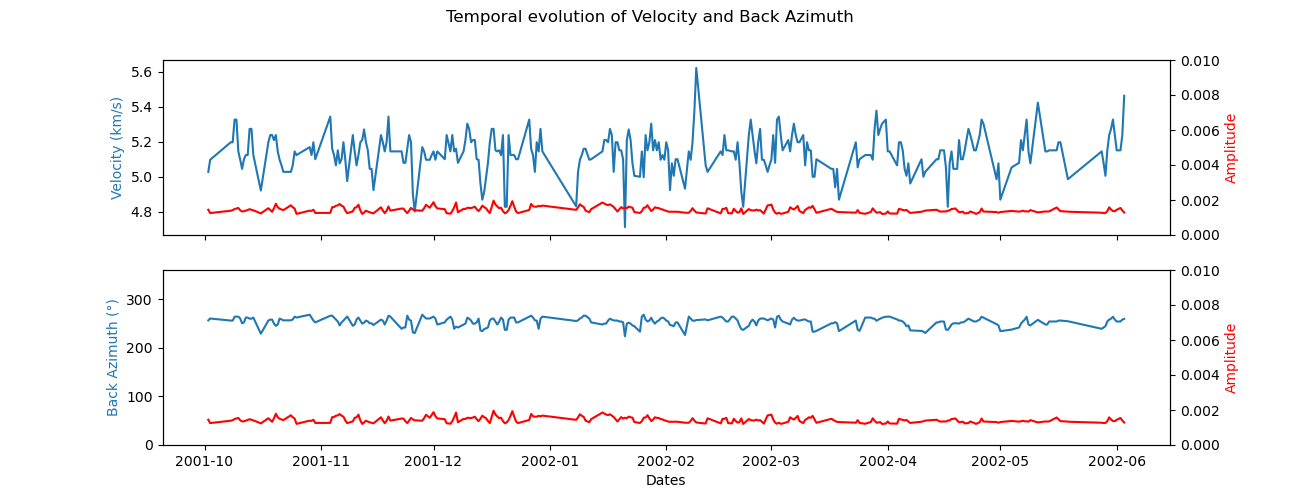

In [9]:
#faire l'interpolation dans la timeserie  car il faut avoir un sampling rate constant avant d'essayer d'appliquer la moving average / la rolling median 
from scipy.interpolate import interp1d

dates_range_converted = np.zeros(len(dates_range_clean))
for i in range(len(dates_range_converted)):
    dates_range_converted[i] = (dates_range_clean[i]-datetime(2001,10,2)).total_seconds() #il compte le nombre de secondes depuis le jour de référence aka le 2 octobre 

#on réalise les trois interpolations linéaires
interp_veloc = interp1d(dates_range_converted, veloc_clean)
interp_baz = interp1d(dates_range_converted, baz_clean)
interp_amplitude = interp1d(dates_range_converted,amplitude_clean)

#on recalcule alors les valeurs associées aux différents jours 
dates_range_resampled = np.arange(dates_range_converted[0],dates_range_converted[-1]+1,12*60*60) #on on fait une inteprolation toutes les 12 heures au lieu de tous els jours seulement

veloc_resampled = interp_veloc(dates_range_resampled)
baz_resampled = interp_baz(dates_range_resampled)
amplitude_resampled = interp_amplitude(dates_range_resampled)
dates_range_resampled = list(dates_range_resampled) #on convertit maintenant en liste car le numpy array va pas vouloir contneir des datetime ibejcts 
print(len(dates_range_resampled))

#maintenant qu'on a resamplé les différentes données il nous faut reconvertir le nombre de jours depuis la référence en véritbales jours 
for i in range(len(dates_range_resampled)):
    dates_range_resampled[i] = datetime(2001,10,2)+timedelta(seconds=dates_range_resampled[i]) #on recalcule les dates associées


plot_clean(dates_range_resampled, veloc_resampled, baz_resampled, amplitude_resampled,
           figname='parkfield_bartlett_cooked_v3_0.8-1.3Hz_resampled_blended_blobs_findpeaks.png')

#c'est bon on a resampled, par contre maintenant les points ne veulent plus rien dire, puisque juste de l'interpolation 

### Moving average results

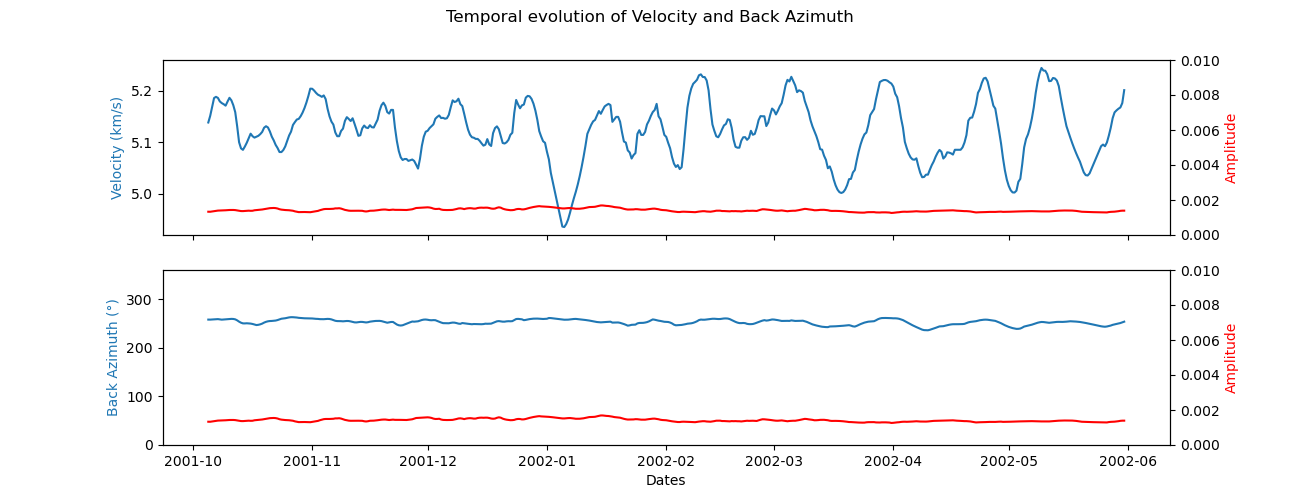

In [10]:
#maintenant on va chercher à trouver un moving aver
width=13 #with = 14 pour faire du 7 jours si on est en mode blended !! 
veloc_ma = moving_average(veloc_resampled,width)
baz_ma = moving_average(baz_resampled,width)
amplitude_ma = moving_average(amplitude_resampled,width)
dates_range_ma = dates_range_resampled[width//2:-(width//2)]
plot_clean(dates_range_ma, veloc_ma, baz_ma, amplitude_ma,
          figname='test.png')
#parkfield_bartlett_cooked_v3_0.8-1.3Hz_resampled_blended_w13_ma_blobs_findpeaks

# Recherche de la localisation de la source en fonction du temps

In [14]:
from obspy.geodetics.base import gps2dist_azimuth
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import Stamen, OSM, GoogleTiles
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import distance, geodesic
from pyrocko import cake
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc



def make_date_range_backpropag(date1, date2, step='12h', badbeam_list=None):
    availability_matrix = np.loadtxt('availability_matrix_nobad')
    sdate, edate= pd.to_datetime({'year': [date1[0], date2[0]],
                   'month': [date1[1],date2[1]],
                   'day': [date1[2], date2[2]]})
    dates_range = pd.date_range(sdate,edate-timedelta(days=1),freq=step)
    if date1[0]!=date2[0]: #on retire la date entre 2001 et 2002 car pas gérée par le code
            try:
                dates_range = dates_range.drop('2001-12-31 12:00:00')
            except:
                print('Date was not in range')
    a = len(dates_range)
    print(f'Date range created with {len(dates_range)} dates')
    #doit utiliser fonction en installed days pour trouver les indices dansavailability matrix
    station_threshold = 20
    for date in dates_range:
        if date.hour==0: #si c'est en heure pleine seulement qu'on va chercher à vérifier si on a de la donnée du jour même 
            idx_day = (date-datetime(2001,6,24)).days #calcule le nombre de jour depuis le 24 juin qui est le jour d'installation 0 = le Jday 175
            station_number = np.count_nonzero(availability_matrix[:,idx_day]==1)
            if (date-datetime(2002,1,1)).days+1==102: #calcule le jday pour savoir si c'est le j 102 qui bug
                station_number = 0 #on met alors à 0 car bugged
        elif date.hour==12:
            idx_day1 = (date-datetime(2001,6,24)).days
            idx_day2 = idx_day1+1
            station_number1 = np.count_nonzero(availability_matrix[:,idx_day1]==1)
            station_number2 = np.count_nonzero(availability_matrix[:,idx_day2]==1)
            station_number = np.min([station_number1,station_number2])
            if (date-datetime(2002,1,1)).days+1==102 or (date-datetime(2002,1,1)).days+1==101: #pareil ici, si la date est 4 avril 12h (102+103) ou 3 avril 12h (101+102)
                station_number=0 #alors ça dégage!
        if station_number<station_threshold: #faut avoir au moins 20 bonnes stations pour que beam pas trop mal
            dates_range = dates_range.drop(date) #dans ce cas on drop la date!
    print(f'{len(dates_range)} dates left after removing dates with less than {station_threshold} stations ({a-len(dates_range)} removed)')
    a = len(dates_range)
    #qui plus est on supprime aussi une liste de beams 
    if badbeam_list!=None:
        for badbeam in badbeam_list:
            try:
                dates_range = dates_range.drop(badbeam)
            except:
                if  ((badbeam-dates_range[0]).days+1)>0  and ((dates_range[-1]-badbeam).days+1)>0: #si la date de fin est plus tard que date du beam, alors c'est que date a déjà été retirée! 
                    print('Date already gone!')
    print(f'{len(dates_range)} Dates left after removing those with bad beams ({a-len(dates_range)} removed)')
    return dates_range


def extract_Z_backpropagation(date):
    year = date.year
    jday = (date-datetime(year,1,1)).days+1   #calcul le jday de la date
    if date.hour==12: #cas où il faut blend les deux beams 
        day_first = jday #FOCNTION QUI CONVERTIT  LA DATE EN JOUR JULIEN 
        if day_first!=365:
            day_second = day_first+1
        else:
            day_second = 1 #prend en compte l'effet du switch entre 2001 et 2002!
        
        data1 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_first:03}.h5",'r') 
        data2 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_second:03}.h5",'r')
        fk1   = data1['fk'][()]
        fk2   = data2['fk'][()]
        freqs = data1['ff']['sfreq'][()]   #ça devrait pas matter si on prend depuis le 1 ou le 2
        U    = data1['bb']['U'][()] * 10**3 #
    else: 
        day = jday  
        data = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day:03}.h5",'r') #il importe le fichier 
        fk   = data['fk'][()]
        freqs = data['ff']['sfreq'][()]
        U    = data['bb']['U'][()] * 10**3
    
    #c'est bon on a tout maintenant on a plus qu'à importer Z!! 
    for j in range(len(pl_updated['fn'])):
        ifreq = m_beam.make_short_freq(pl_updated['fn'][j],freqs,fw=pl_updated['fw'],nf=0)
        if date.hour==12:   #pareil, si on est sur du 12h alors faut que ça chevauche les deux jours  
            Z1 = np.mean(np.abs(fk1[ifreq,:,:]),axis=0).transpose()
            Z2 = np.mean(np.abs(fk2[ifreq,:,:]),axis=0).transpose()
            Z  = (Z1+Z2)/2 #on fait la moyenne des beams des deux jours différents !
        else: #si int(days) = days alors c'est qu'on est sur un jour spécifique et donc on a déjà son Z grâce au fk
            Z = np.mean(np.abs(fk[ifreq,:,:]),axis=0).transpose() #on a supprimé l'option pour faire
    return Z #pas beosoin de ressortir le 0.8 à 1.3 Hz 


def find_p(distance, p_option='ray',model=None,Phase=None,source_depth=None):
    '''fonction servant à trouver la slowness apparente, basée sur la distance entre le point et le barycentre. 2 modes dispos:
    ray pour raytracing et fw pour full waveform 
    on lui feed direct le vecteur dis et slow au lieu de lire le fichier à chaque fois si mode fw'''
    if p_option=='ray':
        distances = np.linspace(distance-1,distance+1,3)*cake.m2d #converison de la distance en degrés 
        arrivals = model.arrivals(distances, phases=Phase, zstart=source_depth)
        best_efficiency = 0
        #il y a probablement plusieurs arrivals à la même distance, on choisi alors cette qui a la plus forte efficiency 
        p=1.0
        for arrival in arrivals:
            if arrival.efficiency()>=best_efficiency:
                best_efficiency = arrival.efficiency()
                p = arrival.p*np.pi/180/cake.d2m*1000. #on récupère alors le paramètre de rai associé à cette meilleure arrivée!
    else:
        p = model[1,[np.argmin(abs(model[0,:]-distance))]][0] #là dans le slowness profile on récupère la valeur la plus adaptée au vue de la distance : il faudrait 
                                                                #ajouter une donction de distance en mode si distance trop élevée alors 
    return p
    
def compute_backpropag(sdate, edate, step,latitudes, longitudes, badbeam=None,v_model='california_model_v3.m',station_file='stations_rm_nobad.txt',
                       s_depth=0, plot_map=False, p_option='ray'):
    
    print(f"Using beams from {in_['beam_dir']} with {bb['compo']} component")
    dates_range = make_date_range_backpropag(sdate,edate,step,badbeam) # il trouve les diverses dates à plot 
    # on calcule dès maintenant les valeurs de baz et de slowness associées aux divers points du panneau, et on créé alors 2 matrices dans lesuqelles ces valeurs seront  
    U = bb['U']* 1000 #direct importé depuis variables.py
    slow_mesh, baz_mesh = np.zeros((len(U),len(U))), np.zeros((len(U),len(U)))   
    for j in range(len(U)):
        for i in range(len(U)):
            slow_mesh[j,i] = 1/compute_velo(([j],[i]),U) 
            baz_mesh[j,i] = compute_baz(([j],[i]),U) 
    ################################################################### 
    #on calcule aussi les coordonnées du barycentre pour trouver le backazimuth et la distance du point gps vis à vis du barycentre, besoin d'adapter 
    #le fichier servant à calculer le barycentre en fonction des circonstances, car pas tjr même nb de stations !!    
    lon_bary, lat_bary,height_bary   = compute_barycenter(station_file) #calcule coordonnées du barycentre
    ############################################################## définition de constantes pour la backprogation
    if p_option =='ray': 
        model = cake.load_model(v_model)
        source_depth = s_depth * 1000. #conversion en m
        Phase = cake.PhaseDef('P')
    else:
        model = np.loadtxt(v_model) #on utilise le même argument que 
        source_depth, Phase = None, None
    ###################################################
    
    Z_mesh = np.zeros((len(latitudes),len(longitudes),len(dates_range)))
    
    print('Computing backpropagations, please wait...')
    for d, date in enumerate(tqdm(dates_range)):
        #on extract le beam du jour!
        Z = extract_Z_backpropagation(date)
        for j, lat in enumerate(latitudes):
            for i, lon, in enumerate(longitudes):
                #on calcule la distance en km entre le bary et le pt de coords 
                distance, baz, az = gps2dist_azimuth(lat_bary,lon_bary,lat,lon) #va de array vers source dans ce sens, donc first est le baz qu'on a 
                if distance>=np.min(model[0,:]) and distance<=np.max(model[0,:]):   #############" condition pour que si point en dehors de la range alors direct on met nan dans la matrice !! 
                    p = find_p(distance=distance,p_option=p_option,model=model, source_depth=source_depth, Phase=Phase)
                    #maintenant que l'on a le paramètre de rai, et le baz, on va pouvoir trouver la position de ce best dans les mesh !!
                    #puisque la 
                    if abs(p)>0.4242: #s'il est en dehors du cadre
                        Z_mesh[j,i,d] = 0   
                    else: #maintenant on va réellement devoir chercher les coordonnées du point ainsi que la valeur de Z associée ! 
                        conv = False
                        ecart = 0.002
                        while conv==False: #on lui fait un faible écart au départ pour essayer d'avoir une bonne résolution, mais si ça empêche d'avoir le cercle alors increased
                            ecart = 2*ecart
                            slow_y_low, slow_x_low  = np.where(slow_mesh<p-ecart) 
                            slow_y_high, slow_x_high = np.where(slow_mesh>p+ecart) #on cherche à créer un cercle de 1 sur lequel on cherche l'index du bon BAZ
                            circle = np.ones(slow_mesh.shape)
                            circle[slow_y_low, slow_x_low] = 0
                            circle[slow_y_high, slow_x_high] = 0
                            if np.sum(np.sum(circle))>0:
                                conv = True
                        #c'est bon on a notre cercle !
                        baz_correct = -999
                        loc_correct = -999 #on donne des valeurs fausses juste pour initiliser
                        y_circle, x_circle = np.where(circle==1) #on a une liste de x et de y du circle, on va alors chercher pour ces coordonnées dans le mesh où c'est le plus proche du baz 
                        idef = np.argmin(abs(baz_mesh[y_circle, x_circle]-baz)) #on cherche indice dans liste de points du cercle qui permet d'avoir le baz le plus proche 
                        loc_correct = [[y_circle[idef]],[x_circle[idef]]]
                        #on connait maintenant la bonne location en indexs dans Z, il nous suffit de récupérer la valeur dans Z aka le beam! 
                        Z_mesh[j,i,d] = Z[loc_correct[0],loc_correct[1]] #c'est bon ! on a maintenant remplila cellule du mesh avec l'ampltude de Z associée!                            
                else:
                    Z_mesh[j,i,d] = np.nan #si au dela de la la range de dustances du modèle !!!
                
        if plot_map==True:#option pour directement plot quand ça tourne 
            fig = plot_backpropagation(dates_range[d],latitudes,longitudes, Z_mesh[:,:,d])
            n = 0
            for lat in latitudes:
                for lon in longitudes:
                    n+=1
                    plt.text(lon, lat, str(n),color='red',transform=ccrs.PlateCarree())
            
    return dates_range, Z_mesh  
                    


def plot_backpropagation(dates_range, latitudes, longitudes, Z_mesh,folder='test',lims=None, plot_eq=None, station_file='stations_rm_nodbad.txt',
                        plt_time=False, normalize=False,plot_bathymetry=None):
    stamen_terrain = Stamen(desired_tile_form="RGB", style="terrain-background") 
    
    longitudes_station,latitudes_station,heights_station = extract_coordinates(station_file) #récupère les coordoonées des stations pour le plot
    lon_bary, lat_bary,height_bary   = compute_barycenter(station_file) #calcule coordonnées du barycentre
    
    extent = [longitudes[0], longitudes[-1], latitudes[0], latitudes[-1]]
    
    path = f'/summer/faultscan/user/parisnic/m1_internship/parkfield/BACKPROPAGATION_FIGS/{folder}'
    
    try:
        os.makedirs(path) 
    except:
        if isinstance(dates_range, pd.DatetimeIndex)==True: #pour qu'il print pas si seulement 1 date !
            print('Folder already exists, files will be replaced')
    
    
    if isinstance(dates_range, pd.DatetimeIndex)==True:
        print('Plotting backpropagation at every date ...')
    
    try: #fait avec try comme ça si ça marche pas car 1 seule date, on peut aussi gérer 
        for i in tqdm(range(len(dates_range))):
            plt.close('all')
            plt.figure(figsize=(12, 6))
            ax = plt.axes(projection=ccrs.PlateCarree())
            ax.set_extent(extent)
            ax.add_image(stamen_terrain, 8)
            ax.coastlines()        

            if normalize==True:
                non_nan_loc = np.where(np.isnan(Z_mesh[:,:,i])==False)
                coeff = 1/(Z_mesh[non_nan_loc,i].max()-Z_mesh[non_nan_loc,i].min())
                Z_mesh[:,:,i] = Z_mesh[:,:,i]*coeff-coeff*Z_mesh[non_nan_loc,i].min()
            
            if lims==None:
                non_nan_loc = np.where(np.isnan(Z_mesh[:,:,i])==False)
                lims = [Z_mesh[non_nan_loc,i].min(), Z_mesh[non_nan_loc,i].max()]
              
            if plot_bathymetry!=None:
                lat_bathy,lon_bathy,z_bathy = import_bathymetry(path=plot_bathymetry,extent=extent)
                XX,YY = np.meshgrid(lon_bathy,lat_bathy)
                contour = ax.contour(XX,YY,z_bathy, transform=ccrs.PlateCarree(),colors='black',linestyles='-')
                clabels = plt.clabel(contour, fmt='%d', colors='black', inline=True, inline_spacing=15, fontsize=10)
            
            hmap = ax.pcolormesh(longitudes, latitudes, Z_mesh[:,:,i],
                 transform=ccrs.PlateCarree(), cmap='gist_stern_r',alpha=0.5, vmin=lims[0], vmax=lims[1],
                                linewidth=0, rasterized=True, zorder=10)

            axins = inset_axes(ax,
            width="3%",  # width: 5% of parent_bbox width
            height="100%",  # height: 50%
            loc="lower left",
            bbox_to_anchor=(1.01, 0., 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0,
            )    
            
            cbar = plt.colorbar(hmap,location='right', cax=axins)
            
            ax.scatter(longitudes_station, latitudes_station, color='forestgreen',edgecolors='black', marker='^', transform=ccrs.PlateCarree())
            # ax.scatter(lon_bary, lat_bary, color='green', marker='*', transform=ccrs.PlateCarree())
            
            if plot_eq!=None: #peut aussi plot la position de l'eq si nécessaire !
                ax.scatter(plot_eq[1],plot_eq[0],c='red', marker='*',s=100) #on échait format lat lon, donc inversion pour le scatter
            
            
            
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0, color='gray', alpha=0.3, linestyle='-')

            gl.bottom_labels = False
            gl.right_labels = False
            
            if plt_time==True:
                plt.text(0.4,-0.08,f'{dates_range[i]}',transform=ax.transAxes)

            plt.savefig(f'{path}/map_pcolormesh_{dates_range[i]}.pdf', bbox_inches='tight',dpi=300)
            
    except:
        plt.close('all')
        plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent(extent)
        stamen_terrain = Stamen(desired_tile_form="RGB", style="terrain-background") 
        ax.add_image(stamen_terrain, 8)
        ax.coastlines()        
        
        if normalize==True:
            non_nan_loc = np.where(np.isnan(Z_mesh[:,:])==False)
            coeff = 1/(Z_mesh[non_nan_loc].max()-Z_mesh[non_nan_loc].min())
            Z_mesh = Z_mesh*coeff-coeff*Z_mesh[non_nan_loc].min()
        
        #creating the levels for the cbar :
        if lims==None:
            non_nan_loc = np.where(np.isnan(Z_mesh[:,:])==False)
            lims = [Z_mesh[non_nan_loc].min(), Z_mesh[non_nan_loc].max()]
        
        if plot_bathymetry!=None:
            lat_bathy,lon_bathy,z_bathy = import_bathymetry(path=plot_bathymetry,extent=extent)
            XX,YY = np.meshgrid(lon_bathy,lat_bathy)
            contour = ax.contour(XX,YY,z_bathy, transform=ccrs.PlateCarree(),colors='black',linestyles='-')
            clabels = plt.clabel(contour, fmt='%d', colors='black', inline=True, inline_spacing=15, fontsize=10)
        
        hmap = ax.pcolormesh(longitudes, latitudes, Z_mesh[:,:],
                 transform=ccrs.PlateCarree(), cmap='gist_stern_r',alpha=0.5, vmin=lims[0],vmax=lims[1],linewidth=0,rasterized=True,zorder=10)
        
        axins = inset_axes(ax,
        width="3%",  # width: 5% of parent_bbox width
        height="100%",  # height: 50%
        loc="lower left",
        bbox_to_anchor=(1.01, 0., 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0,
        )
        
        cbar = plt.colorbar(hmap,location='right', cax=axins, label='Normalized amplitude')
        
        
        ax.scatter(longitudes_station, latitudes_station, color='forestgreen',edgecolors='black', marker='^', transform=ccrs.PlateCarree())
        # ax.scatter(lon_bary, lat_bary, color='green', marker='*', transform=ccrs.PlateCarree())
        
        if plot_eq!=None: #peut aussi plot la position de l'eq si nécessaire !
            ax.scatter(plot_eq[1],plot_eq[0],c='red',edgecolors='white', marker='*',s=100) #on échait format lat lon, donc inversion pour le scatter
        
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0, color='gray', alpha=0.5, linestyle='-')
        gl.bottom_labels = False
        gl.right_labels = False
        if plt_time==True:
            plt.text(0.4,-0.08,f'{dates_range}',transform=ax.transAxes)
        plt.savefig(f'{path}/map_pcolormesh_{dates_range}.pdf', bbox_inches='tight',dpi=300)
        
def import_bathymetry(path,extent):
    ds = nc.Dataset(path)
    x_range = [ds['x_range'][0], ds['x_range'][1]]
    y_range = [ds['y_range'][0], ds['y_range'][1]]
    x_spacing = ds['spacing'][0]
    y_spacing = ds['spacing'][1]
    longitudes = np.arange(x_range[0],x_range[1]+x_spacing,x_spacing)
    latitudes = np.arange(y_range[0],y_range[1]+y_spacing,y_spacing)
    z = ds['z'][:]
    z = z.reshape(len(latitudes),(len(longitudes)), order='C') #rehsape pour donner forme matrice
    z = z[::-1,:] #on inverse dans l'ordre Y car pour plot avec matplltib c'est ce qu'il faut  
    ###on slice à présent la zone souhaitée 
    idx_xmin, idx_xmax = np.argmin(np.abs(longitudes-extent[0])),np.argmin(np.abs(longitudes-extent[1])) 
    idx_ymin, idx_ymax = np.argmin(np.abs(latitudes-extent[2])),np.argmin(np.abs(latitudes-extent[3]))
    longitudes = longitudes[idx_xmin:idx_xmax+1]
    latitudes = latitudes[idx_ymin:idx_ymax+1]
    z = z[idx_ymin:idx_ymax+1,idx_xmin:idx_xmax+1]
    z[np.where(z>0)] = np.nan #on met à nan ce qui est à la surface
    return latitudes, longitudes, z

In [10]:
#cellule pour calculer les beams, avec l'option pour les plotter systématiquement 
sdate = (2001,10,13)
edate = (2001,10,14)
step = '12h'

latitudes = np.linspace(35.3, 36.3, 120) #coords pour le noise
longitudes = np.linspace(-122.3,-120.4,120)
station_file = 'stations_rm_nobad.txt'
s_depth = 0


# latitudes = np.linspace(35.6, 37.2, 200)  #coords pour gonzales
# longitudes = np.linspace(-122.5,-120.4,200)
# station_file = 'stations_rm_nobad_gonzales.txt'
# s_depth = 6.575


# latitudes = np.linspace(35.6, 36.3, 9)   #coords pour avenal 
# longitudes = np.linspace(-119.8,-121.0,9)
#station_file = 
#s_depth = 8.8


badbeam_list = [datetime(2001,10,6,12),datetime(2001,10,7),datetime(2001,10,7,12),  #jours 279.5, 280 et 280.5
                datetime(2001,10,22,12),datetime(2001,10,23),datetime(2001,10,23,12), #jours atours de 296
                datetime(2001,11,15,12),datetime(2001,11,16),datetime(2001,11,16,12), #jours autour 320
                datetime(2001,11,20,12),datetime(2001,11,21),datetime(2001,11,21,12), #jours autour 325
                datetime(2001,11,26,12),datetime(2001,11,27),datetime(2001,11,27,12), #jours autour 331
                datetime(2001,12,30,12),datetime(2001,12,31), #jour autour de 365
                datetime(2002,2,4,12), datetime(2002,2,5), datetime(2002,2,5,12), # jour 36
                datetime(2002,2,12,12), datetime(2002,2,13), datetime(2002,2,13,12), # jour 44
                datetime(2002,4,13), datetime(2002,4,13,12), # jour 103 et 103.5
                datetime(2002,4,28,12),datetime(2002,4,29),datetime(2002,4,29,12), #jour 119
                datetime(2002,5,1,12),datetime(2002,5,2),datetime(2002,5,2,12),datetime(2002,5,3),datetime(2002,5,3,12), #début mai 
                datetime(2002,5,4,12),datetime(2002,5,5),datetime(2002,5,5,12), #jour 125
                datetime(2002,5,9,12),datetime(2002,5,10),datetime(2002,5,10,12), #jour 130
                datetime(2002,5,23),datetime(2002,5,23,12), #jour 143 et 143.5
                datetime(2002,5,24,12),datetime(2002,5,25),datetime(2002,5,25,12),datetime(2002,5,26),datetime(2002,5,26,12) #fin mai 144.5-146.5
                ]    

dates_range, Z_mesh = compute_backpropag(sdate, edate, step,latitudes, longitudes, badbeam=badbeam_list,v_model='slowness_gonzales_beam_resampled_smoothed', s_depth=s_depth,
                                         plot_map=False,p_option='fw', station_file=station_file) 

Using beams from save_beam/glob/parkfield_bartlett_cooked_v3 with Z component
Date range created with 1 dates
1 dates left after removing dates with less than 20 stations (0 removed)
1 Dates left after removing those with bad beams (0 removed)
Computing backpropagations, please wait...


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


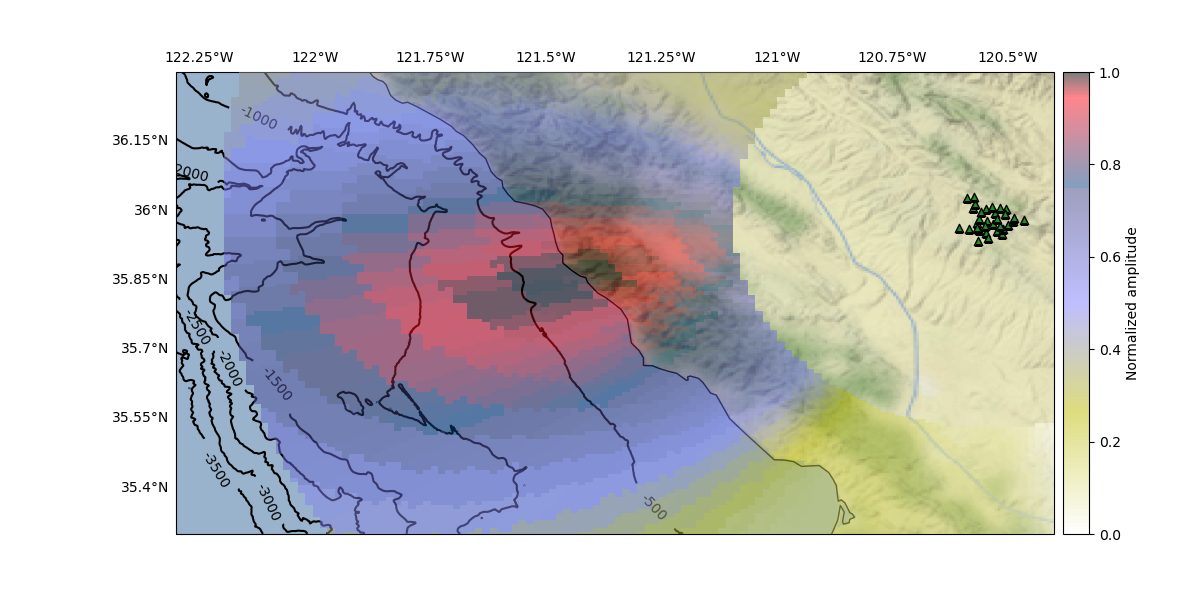

In [15]:
#cellule pour plotter ce qui a été fait dans le job interactif 
clim = [0,1]#[5e-4,1.7e-3] #[0.9,1.0] #None #[3e-4,1.7e-3] #la clim est utile si on veut voir l'évolution notament pour timeserie du noise 
folder = 'noise_good_color_normalized_wbathy'
# eq_coords = (36.640,-121.251) #eq coords gonzales
# eq_coords = ()
# eq_coords = (36.056,-120.139) #eq coords avenal
eq_coords = None  #pour le noise 
plot_backpropagation(dates_range[0],latitudes, longitudes,Z_mesh[:,:,0],folder=folder, lims=clim, plot_eq=eq_coords, station_file=station_file,
                    plt_time=False, normalize=True, plot_bathymetry='map_garde_good.nc')

Date range created with 1 dates
1 dates left after removing dates with less than 20 stations (0 removed)
1 Dates left after removing those with bad beams (0 removed)
Shape before reshaping (30, 40)
Shape expected : (30, 40, 1)
Shape after reshaping : (30, 40, 1)


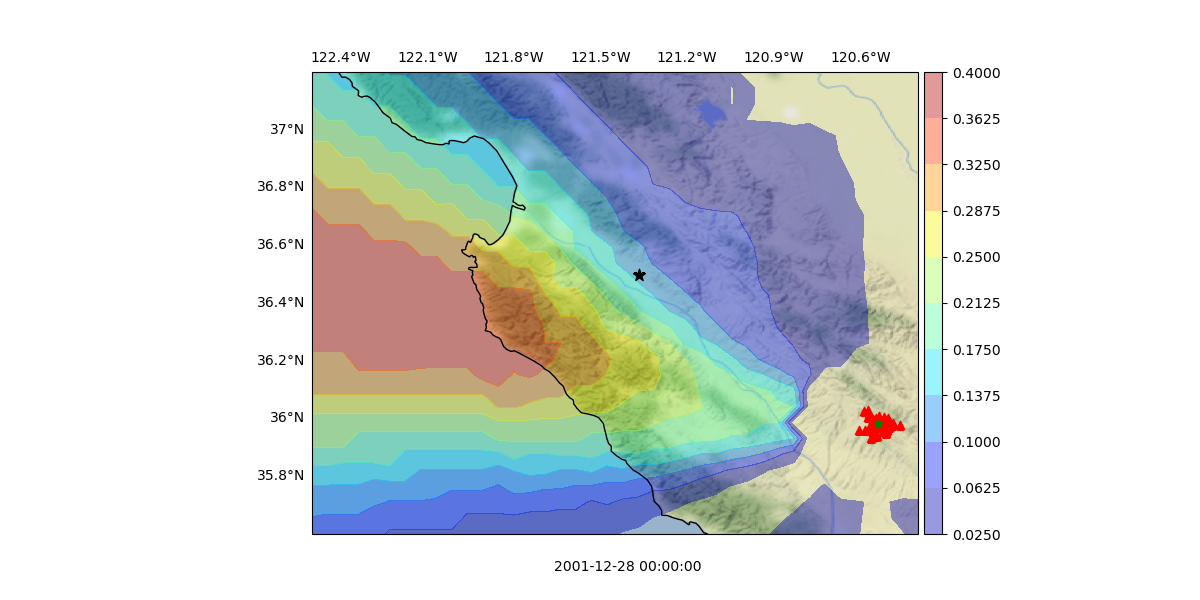

In [11]:
#cellule pour plotter à partir de ce qui a été fait avec le job passif (pour le moment seulement rai tracing de codé)
sdate = (2001,12,28)
edate = (2001,12,29)
step = '12h'

badbeam_list = [datetime(2001,10,6,12),datetime(2001,10,7),datetime(2001,10,7,12),  #jours 279.5, 280 et 280.5
                datetime(2001,10,22,12),datetime(2001,10,23),datetime(2001,10,23,12), #jours atours de 296
                datetime(2001,11,15,12),datetime(2001,11,16),datetime(2001,11,16,12), #jours autour 320
                datetime(2001,11,20,12),datetime(2001,11,21),datetime(2001,11,21,12), #jours autour 325
                datetime(2001,11,26,12),datetime(2001,11,27),datetime(2001,11,27,12), #jours autour 331
                datetime(2001,12,30,12),datetime(2001,12,31), #jour autour de 365
                datetime(2002,2,4,12), datetime(2002,2,5), datetime(2002,2,5,12), # jour 36
                datetime(2002,2,12,12), datetime(2002,2,13), datetime(2002,2,13,12), # jour 44
                datetime(2002,4,13), datetime(2002,4,13,12), # jour 103 et 103.5
                datetime(2002,4,28,12),datetime(2002,4,29),datetime(2002,4,29,12), #jour 119
                datetime(2002,5,1,12),datetime(2002,5,2),datetime(2002,5,2,12),datetime(2002,5,3),datetime(2002,5,3,12), #début mai 
                datetime(2002,5,4,12),datetime(2002,5,5),datetime(2002,5,5,12), #jour 125
                datetime(2002,5,9,12),datetime(2002,5,10),datetime(2002,5,10,12), #jour 130
                datetime(2002,5,23),datetime(2002,5,23,12), #jour 143 et 143.5
                datetime(2002,5,24,12),datetime(2002,5,25),datetime(2002,5,25,12),datetime(2002,5,26),datetime(2002,5,26,12) #fin mai 144.5-146.5
                ]    

dates_range= make_date_range_backpropag(sdate,edate,step,badbeam_list=badbeam_list)

#cellule où on importe le résultat du run passif pour voir regarder rapidement !!!
################"
# latitudes = np.linspace(35.5, 36.1, 30) #coords pour le noise
# longitudes = np.linspace(-121.8,-120.4,40)
# station_file = 'stations_rm_nobad.txt'
######################
# latitudes = np.linspace(35.6, 36.3, 30)   #coords pour avenal 
# longitudes = np.linspace(-119.8,-121.0,40)

#####################
latitudes = np.linspace(35.6, 37.2, 30)  #coords pour gonzales
longitudes = np.linspace(-122.5,-120.4,40)
station_file = 'stations_rm_nobad_gonzales.txt'
#################


Z_mesh = np.loadtxt('Z_mesh_ray_v3_gonzales')

print(f'Shape before reshaping {Z_mesh.shape}')
Zshape = np.zeros((len(latitudes),len(longitudes),len(dates_range)))
print(f'Shape expected : {Zshape.shape}')
Z_mesh = Z_mesh.reshape(Z_mesh.shape[0], Z_mesh.shape[1] // Zshape.shape[2], Zshape.shape[2])
print(f'Shape after reshaping : {Z_mesh.shape}')


clim = [0.025,0.40]#None #[5e-4,1.9e-3] 

folder = 'eq_gonzales_w3s_ray_v3'

# eq_coords = (36.056,-120.139) #eq coords avenal
eq_coords = (36.640,-121.251) #pour gonzales 
# eq_coords = None   #si on fait la backproj pour le bruit et non pas pour un eq


plot_backpropagation(dates_range[0], latitudes, longitudes, Z_mesh[:,:,0],folder=folder, lims=clim, mode='contourf',plot_eq=eq_coords)

In [28]:
#cellule juste pour plot un beam avec le blob + range de détection
def extract_velo_baz(year, days,veloc_range=None, baz_range=None,plot_blobs=False, clim=None, blend=False):
    if plot_blobs==True:
        #création du répertoire et création du chemin qui servira à save les figures
        if blend==True: #la seule utilité de rajouter l'argument blend à la fonction!
            folder = in_['beam_dir'][15:] + '_wblobs_wblend' 
        else:
            folder = in_['beam_dir'][15:] + '_wblobs'
        path = f'/summer/faultscan/user/parisnic/m1_internship/parkfield/BEAM_FIGS/{folder}'
        try:
            os.makedirs(path)                 
        except:
            print('Folder already created')
            
    veloc_matrix = np.zeros((len(pl_updated['fn']),len(days)))
    baz_matrix = np.zeros((len(pl_updated['fn']),len(days)))
    amplitude_matrix = np.zeros((len(pl_updated['fn']),len(days)))
    incert_veloc_matrix = np.zeros((2,len(days)))
    incert_baz_matrix = np.zeros((2,len(days)))
    
    print(f'Processing {year} data, please wait...')  
    
    for i in tqdm(range(len(days))):
        if int(days[i])!=days[i]: #si blend est true, alors il y a des floats .5 et donc cette égalité est pas respectée 
            day_first = int(days[i])
            day_second = day_first+1
            data1 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_first:03}.h5",'r') 
            data2 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_second:03}.h5",'r')
            fk1   = data1['fk'][()]
            fk2   = data2['fk'][()]
            freqs = data1['ff']['sfreq'][()]   #ça devrait pas matter si on prend depuis le 1 ou le 2
            U    = data1['bb']['U'][()] * 10**3 #doit direct utiliser U pour les calculs avec x et y!!!
        else: #si respectée 2 poss, soit c'est que c'est blend mais jour full soit c'est pas blend et donc déjà int
            if isinstance(days[i], float)==True: #si c'est in float alors on le reconverti en int
                day = int(days[i])
            else:
                day = days[i]
            data = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day:03}.h5",'r') #il importe le fichier 
            fk   = data['fk'][()]
            freqs = data['ff']['sfreq'][()]
            U    = data['bb']['U'][()] * 10**3
                
        #on doit d'abord vérifier qu'il  y a de la donnée ce jour là histoire d'éviter un crash! 
        availability_matrix = np.loadtxt('availability_matrix_nobad')
        
        #on doit calculer le nombre de stations, pour ça, soit c'est un jour et ez, soit c'est deux jours et alors on prend le nb minmum entre les deux
        if int(days[i])!=days[i]:
            idx_availability1 = installed_days(year, day_first)
            idx_availability2 = installed_days(year, day_second)
            sta_number1 = np.count_nonzero(availability_matrix[:,idx_availability1]==1)
            sta_number2 = np.count_nonzero(availability_matrix[:,idx_availability2]==1)
            sta_number = np.min([sta_number1,sta_number2])
            if day_first==102 or day_second==102:
                sta_number = 0 #on truque pour que 102 fasse pas planter 
        else:#on peut direct utiliser day ici, car calculé précéemment 
            idx_availability = installed_days(year, day)
            sta_number = np.count_nonzero(availability_matrix[:,idx_availability]==1)
        
        if sta_number>0 and days[i]!=102: #s'assure d'avoir de la donnée avant d'essayer de faire le beamforming
            for j in range(len(pl_updated['fn'])):
                ifreq = m_beam.make_short_freq(pl_updated['fn'][j],freqs,fw=pl_updated['fw'],nf=0)
                
                if int(days[i])!=days[i]:   #pareil, si on est sur un .5, alors on doit blend les deux jours!! 
                    Z1 = np.mean(np.abs(fk1[ifreq,:,:]),axis=0).transpose()
                    Z2 = np.mean(np.abs(fk2[ifreq,:,:]),axis=0).transpose()
                    Z  = (Z1+Z2)/2 #on fait la moyenne des beams des deux jours différents !
                else: #si int(days) = days alors c'est qu'on est sur un jour spécifique et donc on a déjà son Z grâce au fk
                    Z = np.mean(np.abs(fk[ifreq,:,:]),axis=0).transpose() #on a supprimé l'option pour faire la déconvol car travaille qu'en bartlett
                #on passe en échelle db si besoin !
                if pl_updated['db']:
                    Z = 20 * np.log10(Z)
                #maintenant que l'on a correctement traité Z, il a la même alors que sur les plots de beam, et donc les valeurs extraites sont les mêmes que celles
                #attendues à partir des panneaux de beam !
                loc, veloc_matrix[j,i],baz_matrix[j,i],amplitude_matrix[j,i],incert_veloc, incert_baz = find_local_max(Z,U,veloc_range,
                                                                                                                    baz_range,plot_blobs=plot_blobs, clim=clim)
                #on retient aussi l'amplitude du pic trouvé, afin de savoir si c'est un vrai pic ou bien si c'est pas fiable 
                #mais peut y avoir pb si le signal est saturé car apparait forte amplitud ealors que juste pb dans la trace ...
                incert_veloc_matrix[0,i] = incert_veloc[0]
                incert_veloc_matrix[1,i] = incert_veloc[1]
                incert_baz_matrix[0,i] = incert_baz[0]
                incert_baz_matrix[1,i] = incert_baz[1]
                if plot_blobs==True: #on peut à présent sauvegarder !! le fichier dans son folder et sur lequel apparait le jour Julian 
                    # plt.title(f'Day {days[i]} of {year}')
                    plt.savefig(f'{path}/beam_{compo_to_plot}_{year}_day_{days[i]:05}.pdf',bbox_inches='tight', dpi=300)
        else:
            for j in range(len(pl_updated['fn'])):
                loc, veloc_matrix[j,i],baz_matrix[j,i],amplitude_matrix[j,i],incert_baz_matrix[0,i],incert_baz_matrix[1,i] = ([0],[0]), 999,999,0,0,0 
                incert_veloc_matrix[0,i],incert_veloc_matrix[1,i]=0,0 
                
    return veloc_matrix, baz_matrix, amplitude_matrix, incert_veloc_matrix, incert_baz_matrix

def compute_evolution(date1,date2,veloc_range=None,baz_range=None,plot_blobs=False, clim=None, blend=False):
    '''On doit lui input les dates sous forme de tuple (year,month,day)
    Si l'argument blend est passé en true, alors il va mélanger les beams sucessifs, permettant ainsi de doubler le nombre de points (12h du jour 1 de blend)'''
    day1 = date_to_day(date1) #calcul du jour de l'année
    day2 = date_to_day(date2)
    year1 = date1[0]
    year2 = date2[0]
    if year1!=year2: #if they are not the same year -> then we need to perform a concatenation over the years 
        
        if blend==True:
            day_range1 = np.arange(day1,366-0.5,0.5)
            day_range2 = np.arange(1,day2-0.5,0.5)
        else:
            day_range1 = range(day1,366) #on fait la range de jours dans l'année pour savoir quels fichiers inclure dans l'array
            day_range2 = range(1,day2) 
        
        veloc_matrix1, baz_matrix1, amplitude_matrix1,incert_veloc_matrix1, incert_baz_matrix1 = extract_velo_baz(year1,day_range1,
                                                                                            veloc_range=veloc_range, baz_range=baz_range, plot_blobs=plot_blobs,
                                                                                            clim=clim, blend=blend) #on récupère tous les fichiers dans l'année 1 et on extrait les valeurs + calcule les velo + baz
        veloc_matrix2, baz_matrix2, amplitude_matrix2,incert_veloc_matrix2, incert_baz_matrix2 = extract_velo_baz(year2,day_range2,
                                                                                            veloc_range=veloc_range, baz_range=baz_range, plot_blobs=plot_blobs,
                                                                                            clim=clim, blend=blend)
        veloc_matrix_all = np.concatenate((veloc_matrix1,veloc_matrix2),axis=1) #on fait la concaténation sur les deux années
        baz_matrix_all = np.concatenate((baz_matrix1,baz_matrix2),axis=1) 
        amplitude_matrix_all = np.concatenate((amplitude_matrix1,amplitude_matrix2),axis=1) 
        incert_veloc_matrix_all = np.concatenate((incert_veloc_matrix1,incert_veloc_matrix2),axis=1)
        incert_baz_matrix_all = np.concatenate((incert_baz_matrix1,incert_baz_matrix2),axis=1) 
        #on a maintenant besoin d'avoir la liste des dates recouvrant la période sélectionnée, cette liste sera utulisée pour les plots
        dates_range = compute_dates_range(date1,date2,blend=blend)
    else:
        if blend==True:
            day_range = np.arange(day1,day2-0.5,0.5)
        else:
            day_range = range(day1,day2)
            
        veloc_matrix_all, baz_matrix_all, amplitude_matrix_all,incert_veloc_matrix_all, incert_baz_matrix_all = extract_velo_baz(year1,day_range, 
                                                                                                        veloc_range=veloc_range, baz_range=baz_range, plot_blobs=plot_blobs,
                                                                                                        clim=clim, blend=blend) #peu importe qu'on utilsie l'anéne de la première date ou de la deuxième puisque la même
        dates_range = compute_dates_range(date1,date2,blend=blend)
    return dates_range, veloc_matrix_all, baz_matrix_all, amplitude_matrix_all,incert_veloc_matrix_all, incert_baz_matrix_all 

def find_local_max(Z,U,veloc_range=None,baz_range=None,plot_blobs=False, clim=None, thresh_amp=0.95):
    '''Cette fonction a pour vocation de trouver les coordonées du maximum local dans une gamme de vitesse et baz donnée  à l'aide de clustering
    Elle est employée par le mode normal dans la fonction extract velo_baz 
    Fonction séparée pour pouvoir initialement être ajoutée aux plots des panneaux de beamforming pour vérifier que le maximum est correctement localisé!
    La location en output est modifiée par rapport à la location en sortie de np where, de telle sorte à ce que le premier indice = x et deuxième indice = y
    cette fnction retrouve par ailleurs le maximum d'amplitude du cluster, cettte amplitude sera alors plottée dans la timeserie'''
    du   = U[1]-U[0]
    y, x = np.mgrid[min(U)-du/2:max(U)+du/2:U.size+1+1j,min(U)-du/2:max(U)+du/2:U.size+1+1j]
    #On trouve la location des peaks, on cherchera par la suite lequels de ces peaks sont présents dans les blobs!!
    fp = findpeaks(method='topology', verbose=0)
    peaks = fp.fit(Z)
    #on convertit Z en uint8 pour l'utiliser ave cle bloc detector 
    coeff = 255/(np.max(Z)-np.min(Z))
    Z_gray = np.uint8(Z*coeff-np.min(Z)*coeff)
    blobs = blob_log(Z_gray) #c'est bon on a nos blobs,
    #on devrait maintenant avoir extrait les clusters, il faut à présent vérifier pour chaque cluster s'il respecte les conditions données et si c'est le cas alors
    #il ses coordonnées sont gardées 
    velocity = 999 # fonctionnera avec l'option nowave -> on retirera le data point s'il n'avait pas trouvé de cluster respectant les critères!
    velocity_incert = (999,999)
    backazimuth = 999
    backazimuth_incert = (999,999)
    amplitude = -999999999999999999999 
    true_loc = ([0],[0]) #il return aussi la loc pour pouvoir permettre de plotter par la suite le cluster trouvé
    
    if plot_blobs==True:
        plt.close('all')
        fig, ax = plt.subplots(1)
        extent = np.min(x[0,:]), np.max(x[0,:]), np.min(y[:,0]), np.max(y[:,0]) #sert juste pour le plot en imshow, ne pas utilsier x et y pour calculer des valeurs !!
        
        coeff = 1/(Z.max()-Z.min())
        Z = coeff*Z
        Z -= Z.min()
        
        vmin = Z.min()
        vmax = Z.max()
        im = ax.imshow(Z,vmin=vmin, vmax=vmax,origin='lower',extent=extent,cmap=pl_updated['clmap'])
        fig.colorbar(im)
        ax.set_ylabel('slowness (s/km)')
        ax.set_xlabel('slowness (s/km)')
        
        #on plot les différents pics extraits avec axtract peaks, permet de vérifier qu'il fonctionne bien
        peak_number_max = np.count_nonzero(peaks['Xranked']>0)
        for peak_num in range(1,peak_number_max):
            loc_plot = np.where(peaks['Xranked']==peak_num)
            # ax.scatter(U[loc_plot[1]],U[loc_plot[0]], c='green') #commenter pour pas plot les peaks 
        
        for blob in blobs:#on plot les divers blobs
            y_blob, x_blob, r_blob = blob
            y_blob, x_blob = int(y_blob), int(x_blob)
            x_blob_plot,y_blob_plot = U[x_blob],U[y_blob]
            du = x[0,1]-x[0,0] #avoir le pas spatial
            r_blob_plot = r_blob*du #convertit la distance de pixels à vraie distance !
            c_blob = plt.Circle((x_blob_plot,y_blob_plot),r_blob_plot, color='lime', linewidth=3, fill=False, clip_on=True)
            ax.add_patch(c_blob)
        
        ax.set_xlim(extent[0],extent[1])
        ax.set_ylim(extent[2],extent[3])
    
    for blob in blobs: 
        y_blob, x_blob, r_blob = blob #seerivra à trouver les incertitudes ainsi qu'à s'assurer que le pic trouvé est
        y_blob, x_blob = int(y_blob), int(x_blob)
        #On doit trouver le peak avec findpeaks qui est dans le blob et a la plus grande amplitude possible!
        peak_number = 0
        conv = False #on va itérer à travers les différents pics et en trouver un dans le blob
        peak_number_max = np.count_nonzero(peaks['Xranked']>0) #compte le nombre de pics positifs, comme ça si on dépasse le nombre de peaks, alors on arrête de chercher 
        while conv==False and peak_number<peak_number_max: 
            peak_number+=1
            loc = np.where(peaks['Xranked']==peak_number)
            #ddoit maintenant faire une condition pour que le peak dans le blob
            if np.sqrt((loc[0][0]-y_blob)**2+(loc[1][0]-x_blob)**2)<r_blob:
                conv=True
        
        peak_veloc = compute_velo(loc, U)
        peak_baz = compute_baz(loc, U)
        peak_amplitude = Z[loc[0][0],loc[1][0]]
        
        
        incert_veloc_inf = 99999999999
        incert_veloc_sup = 0
        incert_baz_inf = 99999999999
        incert_baz_sup = 0
        
        for j in range(len(U)): #pour tous les points du cluster
            for i in range(len(U)): #l'maplitude threshold se base sur l'amplitude du peak principale du blob considéré
                if np.sqrt((j-y_blob)**2+(i-x_blob)**2)<r_blob and Z[j,i]>thresh_amp*peak_amplitude: #si le pixel considéré est dans le blob, alors on va calculer la vitesse et le BAZ du pixel
                    temp_loc = ([j],[i]) #les coordonnées utilisées sont direct les indexs 
                    temp_veloc  = compute_velo(temp_loc, U) #on calcule la vitesse du point associé 
                    temp_baz  = compute_baz(temp_loc, U) #on calcule alors le baz associé au point 
                    
                    if plot_blobs==True:
                        ax.scatter(U[i],U[j],s=10,color='lime') #juste pour montrer quels points sont considérés quand on calcule l'incertitude !!!
                    
                    if temp_veloc < incert_veloc_inf:
                        incert_veloc_inf = temp_veloc
                    if temp_veloc > incert_veloc_sup: #same s'il est plus grand
                        incert_veloc_sup = temp_veloc
                    if temp_baz < incert_baz_inf: #si le point a un baz inférieur au plus faible baz actuel du cluster alors il le remplace
                        incert_baz_inf = temp_baz
                    if temp_baz > incert_baz_sup: #same s'il est plus grand
                        incert_baz_sup = temp_baz
                
        if  veloc_range[0]<= peak_veloc <= veloc_range[1] and baz_range[0] <= peak_baz <= baz_range[1] and peak_amplitude>amplitude:
            #si amplitude d'un autre blob est supérieure à celle du précédent, alros il sera remplacé 
            velocity = peak_veloc
            velocity_incert = (velocity-incert_veloc_inf, incert_veloc_sup-velocity)
            backazimuth = peak_baz
            backazimuth_incert = (backazimuth-incert_baz_inf, incert_baz_sup-backazimuth) #on fait un tuple qui contient le min et max baz du cluster ->  donne alors une sorte d'incertitude
            amplitude = peak_amplitude  #c'est bon parce que loc contient d'abord indice den y
            true_loc = (loc[1],loc[0]) #on réarrange pour que ce soit les x en premeir puis les y, sert à plotter sur la figure
    
    if plot_blobs==True and true_loc!=([0],[0]): #rajoute le 0,0 car c'est ce qu'on met quand on sait pas où est le max, du coup là on le plot plus 
        ax.scatter(U[true_loc[0]], U[true_loc[1]], marker='*', s=150, edgecolors='black', color='pink')
    
    ax.set_ylim(-0.2,0.1)
    ax.set_xlim(-0.3,-0.1)
        
    return true_loc, velocity, backazimuth, amplitude, velocity_incert ,backazimuth_incert 

0.0016183853149414062
[89 55]
(328,)
0.0006155967712402344
[[89], [55]]


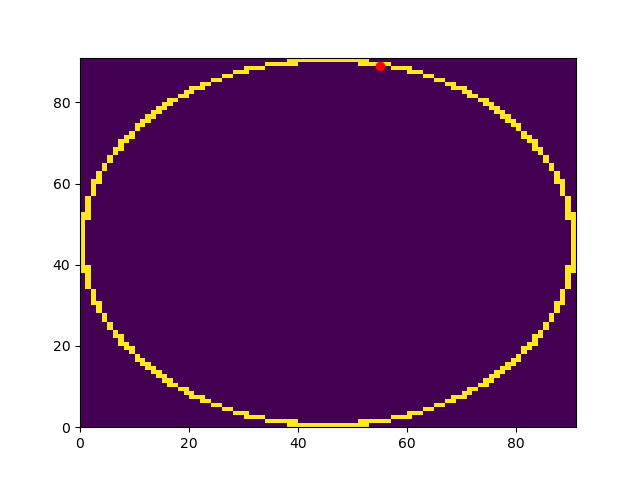

In [21]:
import time

U = bb['U']*1000 #direct importé depuis variables.py
U = np.linspace(-0.3,0.3,91)


slow_mesh, baz_mesh = np.zeros((len(U),len(U))), np.zeros((len(U),len(U)))   
for j,ttt in enumerate((U)):
    for i in range(len(U)):
        slow_mesh[j,i] = 1/compute_velo(([j],[i]),U)
        baz_mesh[j,i] = compute_baz(([j],[i]),U)


        
#on peut juste lui faire increase 
p = 0.3
baz = 13

conv = False
ecart = 0.002
while conv==False: #on lui fait un faible écart au départ pour essayer d'avoir une bonne résolution, mais si ça empêche d'avoir le cercle alors increased
    ecart = 2*ecart
    slow_y_low, slow_x_low  = np.where(slow_mesh<p-ecart) 
    slow_y_high, slow_x_high = np.where(slow_mesh>p+ecart) #on cherche à créer un cercle de 1 sur lequel on cherche l'index du bon BAZ
    circle = np.ones(slow_mesh.shape)
    circle[slow_y_low, slow_x_low] = 0
    circle[slow_y_high, slow_x_high] = 0
    if np.sum(np.sum(circle))>0:
        conv = True
#c'est bon on a notre cercle !

baz_correct = -999
loc_correct = -999 #on donne des valeurs fausses juste pour initiliser

time_start = time.time()
circle_indexes = np.argwhere(circle==1) #on récupère la liste des coordonnées des points du cercle 
for loc in circle_indexes:
    y, x = loc[0], loc[1] #récupère y et x qui sont des int 
    baz_temp = compute_baz([[y],[x]],U) #on les met sous la forme utilisée par la focntion
    if abs(baz-baz_temp)<abs(baz-baz_correct):
        baz_correct = baz_temp
        loc_correct = loc #on retient les coordonnées du point !
#on connait maintenant la bonne location 
print(time.time()-time_start)
print(loc_correct)
        
    
#plus simple et plus rapide pour trouver le bon baz!!! 
time_start = time.time()
y_circle, x_circle = np.where(circle==1) #on a une liste de x et de y du circle 
idef = np.argmin(abs(baz_mesh[y_circle, x_circle]-baz)) #on cherche alros à trouver parmi baz mesh de ces indice lequel a des points a un baz le plus proche de cleui qu'on veut! 
print(baz_mesh[y_circle, x_circle].shape)
loc_correct = [[y_circle[idef]],[x_circle[idef]]]
print(time.time()-time_start)
print(loc_correct)

    
#maintenant on a notre superbe cercle; il ne reste plus qu'à trouver le bon BAZ sur le cercle !!!
        
        
plt.figure()
plt.pcolormesh(circle)
plt.scatter(loc_correct[1],loc_correct[0], color='red')

In [ ]:
# widths=np.arange(3,83,4) 

# fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(13,5))
# fig.suptitle('Temporal evolution of Velocity and Back Azimuth for various moving average window lengths')
# ax1.set_ylabel('Velocity (km/s)')
# ax2.set_ylabel('Back Azimuth (°)')
    

# for i, width in enumerate(widths):
#     veloc_ma = moving_average(veloc_resampled,width)
#     baz_ma = moving_average(baz_resampled,width)
#     ax1.plot(dates_range_resampled[width//2:-(width//2)],veloc_ma, label=f'w={width} days')
#     ax2.plot(dates_range_resampled[width//2:-(width//2)],baz_ma, label=f'w={width} days')
    
# ax1.legend()
# ax2.legend()

Date was not in range
Date range created with 245 dates
227 dates left after removing dates with less than 20 stations (18 removed)
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
Date already gone!
211 Dates left after removing those with bad beams (16 removed)
DatetimeIndex(['2001-10-02', '2001-10-03', '2001-10-04', '2001-10-05',
               '2001-10-06', '2001-10-08', '2001-10-09', '2001-10-10',
               '2001-10-11', '2001-10-12',
               ...
               '2002-05-19', '

100%|██████████████████████████████████████████████████████████████| 211/211 [06:52<00:00,  1.95s/it]


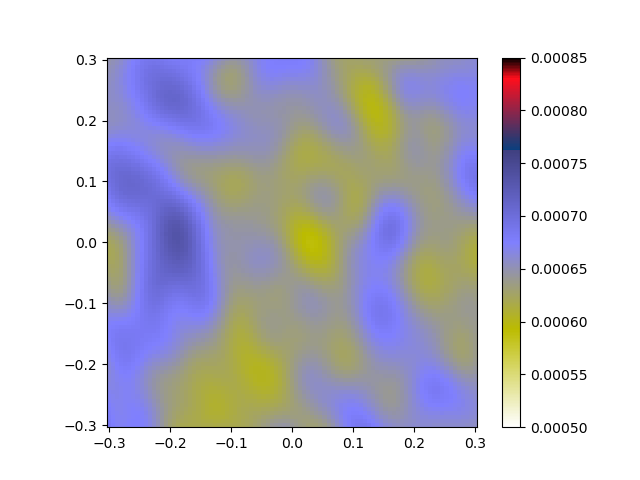

In [4]:
#pour test on fait un stack de l'horizontal component sur l'ensemble de la durée d'enregistrement 

#CELLULE POUR DAIRE DU FULL TIME STACK !!!

sdate = (2001,12,20)
edate = (2002,12,20)
step = '24h'



badbeam_list = [datetime(2001,10,6,12),datetime(2001,10,7),datetime(2001,10,7,12),  #jours 279.5, 280 et 280.5
                datetime(2001,10,22,12),datetime(2001,10,23),datetime(2001,10,23,12), #jours atours de 296
                datetime(2001,11,15,12),datetime(2001,11,16),datetime(2001,11,16,12), #jours autour 320
                datetime(2001,11,20,12),datetime(2001,11,21),datetime(2001,11,21,12), #jours autour 325
                datetime(2001,11,26,12),datetime(2001,11,27),datetime(2001,11,27,12), #jours autour 331
                datetime(2001,12,30,12),datetime(2001,12,31), #jour autour de 365
                datetime(2002,2,4,12), datetime(2002,2,5), datetime(2002,2,5,12), # jour 36
                datetime(2002,2,12,12), datetime(2002,2,13), datetime(2002,2,13,12), # jour 44
                datetime(2002,4,13), datetime(2002,4,13,12), # jour 103 et 103.5
                datetime(2002,4,28,12),datetime(2002,4,29),datetime(2002,4,29,12), #jour 119
                datetime(2002,5,1,12),datetime(2002,5,2),datetime(2002,5,2,12),datetime(2002,5,3),datetime(2002,5,3,12), #début mai 
                datetime(2002,5,4,12),datetime(2002,5,5),datetime(2002,5,5,12), #jour 125
                datetime(2002,5,9,12),datetime(2002,5,10),datetime(2002,5,10,12), #jour 130
                datetime(2002,5,23),datetime(2002,5,23,12), #jour 143 et 143.5
                datetime(2002,5,24,12),datetime(2002,5,25),datetime(2002,5,25,12),datetime(2002,5,26),datetime(2002,5,26,12) #fin mai 144.5-146.5
                ]    

dates_range= make_date_range_backpropag(sdate,edate,step,badbeam_list=badbeam_list)

print(dates_range)

Z_annual_stack = np.zeros((91,91)) 

for i, date in enumerate(tqdm(dates_range)):
    Z_import = extract_Z_backpropagation(date)
    Z_annual_stack[:,:] = Z_annual_stack[:,:]+Z_import
    
Z_annual_stack = Z_annual_stack/len(dates_range)


fig, ax = plt.subplots(1)
U = np.linspace(-0.3,0.3,91)
du   = U[1]-U[0]
y, x = np.mgrid[min(U)-du/2:max(U)+du/2:U.size+1+1j,min(U)-du/2:max(U)+du/2:U.size+1+1j]
extent = np.min(x[0,:]), np.max(x[0,:]), np.min(y[:,0]), np.max(y[:,0])


im = ax.imshow(Z_annual_stack,vmin=5e-4, vmax=0.85e-3,origin='lower',extent=extent,cmap=pl_updated['clmap'])
plt.colorbar(im)


In [ ]:
def extract_Z_backpropagation(date):
    year = date.year
    jday = (date-datetime(year,1,1)).days+1   #calcul le jday de la date
    if date.hour==12: #cas où il faut blend les deux beams 
        day_first = jday #FOCNTION QUI CONVERTIT  LA DATE EN JOUR JULIEN 
        if day_first!=365:
            day_second = day_first+1
        else:
            day_second = 1 #prend en compte l'effet du switch entre 2001 et 2002!
        
        data1 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_first:03}.h5",'r') 
        data2 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_second:03}.h5",'r')
        fk1   = data1['fk'][()]
        fk2   = data2['fk'][()]
        freqs = data1['ff']['sfreq'][()]   #ça devrait pas matter si on prend depuis le 1 ou le 2
        U    = data1['bb']['U'][()] * 10**3 #
    else: 
        day = jday  
        data = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day:03}.h5",'r') #il importe le fichier 
        fk   = data['fk'][()]
        freqs = data['ff']['sfreq'][()]
        U    = data['bb']['U'][()] * 10**3
    
    #c'est bon on a tout maintenant on a plus qu'à importer Z!! 
    for j in range(len(pl_updated['fn'])):
        ifreq = m_beam.make_short_freq(pl_updated['fn'][j],freqs,fw=pl_updated['fw'],nf=0)
        if date.hour==12:   #pareil, si on est sur du 12h alors faut que ça chevauche les deux jours  
            Z1 = np.mean(np.abs(fk1[ifreq,:,:]),axis=0).transpose()
            Z2 = np.mean(np.abs(fk2[ifreq,:,:]),axis=0).transpose()
            Z  = (Z1+Z2)/2 #on fait la moyenne des beams des deux jours différents !
        else: #si int(days) = days alors c'est qu'on est sur un jour spécifique et donc on a déjà son Z grâce au fk
            Z = np.mean(np.abs(fk[ifreq,:,:]),axis=0).transpose() #on a supprimé l'option pour faire
    return Z #pas beosoin de ressortir le 0.8 à 1.3 Hz 

In [ ]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import Stamen, OSM, GoogleTiles
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import distance, geodesic
from pyrocko import cake

def plot_source(dates_range, veloc, baz, extent, folder, v_model):
    # v_true = pd.read_table('california_model.m',header=None, delim_whitespace=True)[1][0] #lis dans le fichier la vitesse à la surface des ondes P
    # imagery = OSM()
    stamen_terrain = Stamen(desired_tile_form="RGB", style="terrain-background") 
    
    longitudes,latitudes,heights = extract_coordinates('stations_rm_nobad.txt') #récupère les coordoonées des stations pour le plot
    lon_bary, lat_bary,height_bary   = compute_barycenter('stations_rm_nobad.txt') #calcule coordonnées du barycentre
    
    path = f'/summer/faultscan/user/parisnic/m1_internship/parkfield/MAP_SOURCE_FIGS/{folder}'
    
    try:
        os.makedirs(path) 
    except:
        print('Folder already exists, files will be replaced')
    
    print('Locating daily sources ...')
    for i in tqdm(range(len(dates_range))): #resampled dans la range où il y a des points de la moving average 
        plt.close('all') #on ferme els figs pour éviter d'en avoir 40 mille
        plt.figure(figsize=(12, 6))
        
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent(extent)

        ax.add_image(stamen_terrain, 8)
        
        ax.scatter(longitudes, latitudes, color='blue', marker='^', transform=ccrs.PlateCarree())
        ax.scatter(lon_bary, lat_bary, color='green', marker='*', transform=ccrs.PlateCarree())

        slow = 1/veloc[i]
        km = 1000.
        model = cake.load_model(v_model)
        source_depth = 0 * km #on fait une source au fond de l'eau 
        # Distances as a numpy array [deg].
        distances = np.arange(10, 250, 2)*km * cake.m2d #cake m2d convertir sans doute les mètres en degrés idk, donc on pourrait direct lui input en degré et output en degrés, 
        # Define the phase to use.
        Phase = cake.PhaseDef('P')
        #calcule les arrivées associées 
        arrivals = model.arrivals(distances, phases=Phase, zstart=source_depth)
        closest_slow = 0
        delta_km = 0
        for j, arrival in enumerate(arrivals):
            p = arrival.p*np.pi/180/cake.d2m*km #donne la slowness a comaprer avec celle du plot!
            if arrival.efficiency() == 1.0:
                if abs(p-slow) < abs(closest_slow-slow):
                    closest_slow = p
                    delta_km = arrival.x*cake.d2m/km
        lat_source, lon_source, height_source = distance(kilometers=delta_km).destination((lat_bary, lon_bary), baz[i])

      
        ax.scatter(lon_source,lat_source,
                 color='red', marker='*',
                 transform=ccrs.PlateCarree(),
                 )

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.bottom_labels = False
        gl.right_labels = False

        plt.text(0.4,-0.08,f'{dates_range[i]}',transform=ax.transAxes)

        plt.savefig(f'{path}/map_source_{dates_range[i]}.png', bbox_inches='tight')
        

In [ ]:
'''Params'''
extent = [-121.8, -120.4, 35.5, 36.1]
folder='7_day_window_v3_wblobs'
plot_source(dates_range_clean, veloc_clean, baz_clean,extent, folder, v_model='california_model_v3.m')
# plot_source(dates_range_ma, veloc_ma, baz_ma,extent, folder, v_model='california_model_v3.m') #on peut use soit la version ma qui est la version lissée des positions 
#soit on peut use directement les données 

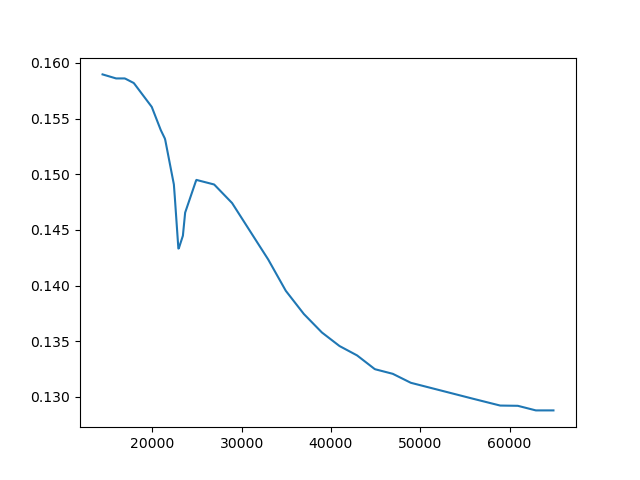

In [9]:
model = np.loadtxt('slowness_avenal_resampled')
plt.figure()
plt.plot(model[0,:],model[1,:])

In [2]:
from pyrocko import moment_tensor as pmt
from pyrocko.plot import beachball
from pyrocko import gf
from matplotlib import transforms, pyplot as plt



magnitude = 4.7  # Magnitude of the earthquake

m0 = 1.003e+16 

strike = 321
dip = 84
rake = -175
mt = pmt.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=m0)



m6 = [mt.mnn, mt.mee, mt.mdd, mt.mne, mt.mnd, mt.med]  # The six MT components
print(m6)

#doit projeter le long d'un plan donné les valeurs 



# print(m6/mt.scalar_moment())  # normalized MT components

[-9647965853123906.0, 9829716452450514.0, -181750599326607.06, -1977149082170634.0, 1349787852032144.8, 7232004554180.974]


In [4]:
#eq avenal 

magnitude = 3.4
m0 = pmt.magnitude_to_moment(magnitude)
strike = 283
dip = 48
rake = 71
mt = pmt.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=m0)
m6 = [mt.mnn, mt.mee, mt.mdd, mt.mne, mt.mnd, mt.med]  # The six MT components
print(m6)

[-111123421989919.0, -21702981762024.64, 132826403751943.66, -59830402664367.01, -20524955312241.12, 26842659019655.734]


In [ ]:


from obspy.geodetics.base import gps2dist_azimuth
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import Stamen, OSM, GoogleTiles
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import distance, geodesic
from pyrocko import cake
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



def make_date_range_backpropag(date1, date2, step='12h', badbeam_list=None):
    availability_matrix = np.loadtxt('availability_matrix_nobad')
    sdate, edate= pd.to_datetime({'year': [date1[0], date2[0]],
                   'month': [date1[1],date2[1]],
                   'day': [date1[2], date2[2]]})
    dates_range = pd.date_range(sdate,edate-timedelta(days=1),freq=step)
    if date1[0]!=date2[0]: #on retire la date entre 2001 et 2002 car pas gérée par le code
            try:
                dates_range = dates_range.drop('2001-12-31 12:00:00')
            except:
                print('Date was not in range')
    a = len(dates_range)
    print(f'Date range created with {len(dates_range)} dates')
    #doit utiliser fonction en installed days pour trouver les indices dansavailability matrix
    station_threshold = 20
    for date in dates_range:
        if date.hour==0: #si c'est en heure pleine seulement qu'on va chercher à vérifier si on a de la donnée du jour même 
            idx_day = (date-datetime(2001,6,24)).days #calcule le nombre de jour depuis le 24 juin qui est le jour d'installation 0 = le Jday 175
            station_number = np.count_nonzero(availability_matrix[:,idx_day]==1)
            if (date-datetime(2002,1,1)).days+1==102: #calcule le jday pour savoir si c'est le j 102 qui bug
                station_number = 0 #on met alors à 0 car bugged
        elif date.hour==12:
            idx_day1 = (date-datetime(2001,6,24)).days
            idx_day2 = idx_day1+1
            station_number1 = np.count_nonzero(availability_matrix[:,idx_day1]==1)
            station_number2 = np.count_nonzero(availability_matrix[:,idx_day2]==1)
            station_number = np.min([station_number1,station_number2])
            if (date-datetime(2002,1,1)).days+1==102 or (date-datetime(2002,1,1)).days+1==101: #pareil ici, si la date est 4 avril 12h (102+103) ou 3 avril 12h (101+102)
                station_number=0 #alors ça dégage!
        if station_number<station_threshold: #faut avoir au moins 20 bonnes stations pour que beam pas trop mal
            dates_range = dates_range.drop(date) #dans ce cas on drop la date!
    print(f'{len(dates_range)} dates left after removing dates with less than {station_threshold} stations ({a-len(dates_range)} removed)')
    a = len(dates_range)
    #qui plus est on supprime aussi une liste de beams 
    if badbeam_list!=None:
        for badbeam in badbeam_list:
            try:
                dates_range = dates_range.drop(badbeam)
            except:
                if  ((badbeam-dates_range[0]).days+1)>0  and ((dates_range[-1]-badbeam).days+1)>0: #si la date de fin est plus tard que date du beam, alors c'est que date a déjà été retirée! 
                    print('Date already gone!')
    print(f'{len(dates_range)} Dates left after removing those with bad beams ({a-len(dates_range)} removed)')
    return dates_range


def extract_Z_backpropagation(date):
    year = date.year
    jday = (date-datetime(year,1,1)).days+1   #calcul le jday de la date
    if date.hour==12: #cas où il faut blend les deux beams 
        day_first = jday #FOCNTION QUI CONVERTIT  LA DATE EN JOUR JULIEN 
        if day_first!=365:
            day_second = day_first+1
        else:
            day_second = 1 #prend en compte l'effet du switch entre 2001 et 2002!
        
        data1 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_first:03}.h5",'r') 
        data2 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_second:03}.h5",'r')
        fk1   = data1['fk'][()]
        fk2   = data2['fk'][()]
        freqs = data1['ff']['sfreq'][()]   #ça devrait pas matter si on prend depuis le 1 ou le 2
        U    = data1['bb']['U'][()] * 10**3 #
    else: 
        day = jday  
        data = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day:03}.h5",'r') #il importe le fichier 
        fk   = data['fk'][()]
        freqs = data['ff']['sfreq'][()]
        U    = data['bb']['U'][()] * 10**3
    
    #c'est bon on a tout maintenant on a plus qu'à importer Z!! 
    for j in range(len(pl_updated['fn'])):
        ifreq = m_beam.make_short_freq(pl_updated['fn'][j],freqs,fw=pl_updated['fw'],nf=0)
        if date.hour==12:   #pareil, si on est sur du 12h alors faut que ça chevauche les deux jours  
            Z1 = np.mean(np.abs(fk1[ifreq,:,:]),axis=0).transpose()
            Z2 = np.mean(np.abs(fk2[ifreq,:,:]),axis=0).transpose()
            Z  = (Z1+Z2)/2 #on fait la moyenne des beams des deux jours différents !
        else: #si int(days) = days alors c'est qu'on est sur un jour spécifique et donc on a déjà son Z grâce au fk
            Z = np.mean(np.abs(fk[ifreq,:,:]),axis=0).transpose() #on a supprimé l'option pour faire
    return Z #pas beosoin de ressortir le 0.8 à 1.3 Hz 


def find_p(distance, p_option='ray',model=None,Phase=None,source_depth=None):
    '''fonction servant à trouver la slowness apparente, basée sur la distance entre le point et le barycentre. 2 modes dispos:
    ray pour raytracing et fw pour full waveform 
    on lui feed direct le vecteur dis et slow au lieu de lire le fichier à chaque fois si mode fw'''
    if p_option=='ray':
        distances = np.linspace(distance-1,distance+1,3)*cake.m2d #converison de la distance en degrés 
        arrivals = model.arrivals(distances, phases=Phase, zstart=source_depth)
        best_efficiency = 0
        #il y a probablement plusieurs arrivals à la même distance, on choisi alors cette qui a la plus forte efficiency 
        p=1.0
        for arrival in arrivals:
            if arrival.efficiency()>=best_efficiency:
                best_efficiency = arrival.efficiency()
                p = arrival.p*np.pi/180/cake.d2m*1000. #on récupère alors le paramètre de rai associé à cette meilleure arrivée!
    else:
        p = model[1,[np.argmin(abs(model[0,:]-distance))]][0] #là dans le slowness profile on récupère la valeur la plus adaptée au vue de la distance : il faudrait 
                                                                #ajouter une donction de distance en mode si distance trop élevée alors 
    return p
    
def compute_backpropag(sdate, edate, step,latitudes, longitudes, badbeam=None,v_model='california_model_v3.m',station_file='stations_rm_nobad.txt',
                       s_depth=0, plot_map=False, p_option='ray'):
    
    print(f"Using beams from {in_['beam_dir']} with {bb['compo']} component")
    dates_range = make_date_range_backpropag(sdate,edate,step,badbeam) # il trouve les diverses dates à plot 
    # on calcule dès maintenant les valeurs de baz et de slowness associées aux divers points du panneau, et on créé alors 2 matrices dans lesuqelles ces valeurs seront  
    U = bb['U']* 1000 #direct importé depuis variables.py
    slow_mesh, baz_mesh = np.zeros((len(U),len(U))), np.zeros((len(U),len(U)))   
    for j in range(len(U)):
        for i in range(len(U)):
            slow_mesh[j,i] = 1/compute_velo(([j],[i]),U) 
            baz_mesh[j,i] = compute_baz(([j],[i]),U) 
    ################################################################### 
    #on calcule aussi les coordonnées du barycentre pour trouver le backazimuth et la distance du point gps vis à vis du barycentre, besoin d'adapter 
    #le fichier servant à calculer le barycentre en fonction des circonstances, car pas tjr même nb de stations !!    
    lon_bary, lat_bary,height_bary   = compute_barycenter(station_file) #calcule coordonnées du barycentre
    ############################################################## définition de constantes pour la backprogation
    if p_option =='ray': 
        model = cake.load_model(v_model)
        source_depth = s_depth * 1000. #conversion en m
        Phase = cake.PhaseDef('P')
    else:
        model = np.loadtxt(v_model) #on utilise le même argument que 
        source_depth, Phase = None, None
    ###################################################
    
    Z_mesh = np.zeros((len(latitudes),len(longitudes),len(dates_range)))
    
    print('Computing backpropagations, please wait...')
    for d, date in enumerate(tqdm(dates_range)):
        #on extract le beam du jour!
        Z = extract_Z_backpropagation(date)
        for j, lat in enumerate(latitudes):
            for i, lon, in enumerate(longitudes):
                #on calcule la distance en km entre le bary et le pt de coords 
                distance, baz, az = gps2dist_azimuth(lat_bary,lon_bary,lat,lon) #va de array vers source dans ce sens, donc first est le baz qu'on a 
                if distance>=np.min(model[0,:]) and distance<=np.max(model[0,:]):   #############" condition pour que si point en dehors de la range alors direct on met nan dans la matrice !! 
                    p = find_p(distance=distance,p_option=p_option,model=model, source_depth=source_depth, Phase=Phase)
                    #maintenant que l'on a le paramètre de rai, et le baz, on va pouvoir trouver la position de ce best dans les mesh !!
                    #puisque la 
                    if abs(p)>0.4242: #s'il est en dehors du cadre
                        Z_mesh[j,i,d] = 0   
                    else: #maintenant on va réellement devoir chercher les coordonnées du point ainsi que la valeur de Z associée ! 
                        conv = False
                        ecart = 0.002
                        while conv==False: #on lui fait un faible écart au départ pour essayer d'avoir une bonne résolution, mais si ça empêche d'avoir le cercle alors increased
                            ecart = 2*ecart
                            slow_y_low, slow_x_low  = np.where(slow_mesh<p-ecart) 
                            slow_y_high, slow_x_high = np.where(slow_mesh>p+ecart) #on cherche à créer un cercle de 1 sur lequel on cherche l'index du bon BAZ
                            circle = np.ones(slow_mesh.shape)
                            circle[slow_y_low, slow_x_low] = 0
                            circle[slow_y_high, slow_x_high] = 0
                            if np.sum(np.sum(circle))>0:
                                conv = True
                        #c'est bon on a notre cercle !
                        baz_correct = -999
                        loc_correct = -999 #on donne des valeurs fausses juste pour initiliser
                        y_circle, x_circle = np.where(circle==1) #on a une liste de x et de y du circle, on va alors chercher pour ces coordonnées dans le mesh où c'est le plus proche du baz 
                        idef = np.argmin(abs(baz_mesh[y_circle, x_circle]-baz)) #on cherche indice dans liste de points du cercle qui permet d'avoir le baz le plus proche 
                        loc_correct = [[y_circle[idef]],[x_circle[idef]]]
                        #on connait maintenant la bonne location en indexs dans Z, il nous suffit de récupérer la valeur dans Z aka le beam! 
                        Z_mesh[j,i,d] = Z[loc_correct[0],loc_correct[1]] #c'est bon ! on a maintenant remplila cellule du mesh avec l'ampltude de Z associée!                            
                else:
                    Z_mesh[j,i,d] = np.nan #si au dela de la la range de dustances du modèle !!!
                
        if plot_map==True:#option pour directement plot quand ça tourne 
            fig = plot_backpropagation(dates_range[d],latitudes,longitudes, Z_mesh[:,:,d])
            n = 0
            for lat in latitudes:
                for lon in longitudes:
                    n+=1
                    plt.text(lon, lat, str(n),color='red',transform=ccrs.PlateCarree())
            
    return dates_range, Z_mesh  
                    


def plot_backpropagation(dates_range, latitudes, longitudes, Z_mesh,folder='test',lims=None, plot_eq=None, station_file='stations_rm_nodbad.txt'):
    stamen_terrain = Stamen(desired_tile_form="RGB", style="terrain-background") 
    
    longitudes_station,latitudes_station,heights_station = extract_coordinates(station_file) #récupère les coordoonées des stations pour le plot
    lon_bary, lat_bary,height_bary   = compute_barycenter(station_file) #calcule coordonnées du barycentre
    
    extent = [longitudes[0], longitudes[-1], latitudes[0], latitudes[-1]]
    
    path = f'/summer/faultscan/user/parisnic/m1_internship/parkfield/BACKPROPAGATION_FIGS/{folder}'
    
    try:
        os.makedirs(path) 
    except:
        if isinstance(dates_range, pd.DatetimeIndex)==True: #pour qu'il print pas si seulement 1 date !
            print('Folder already exists, files will be replaced')
    
    
    if isinstance(dates_range, pd.DatetimeIndex)==True:
        print('Plotting backpropagation at every date ...')
    
    try: #fait avec try comme ça si ça marche pas car 1 seule date, on peut aussi gérer 
        for i in tqdm(range(len(dates_range))):
            plt.close('all')
            plt.figure(figsize=(12, 6))
            ax = plt.axes(projection=ccrs.PlateCarree())
            ax.set_extent(extent)
            ax.add_image(stamen_terrain, 8)
            ax.coastlines()        

            if lims!=None:
                levels = ticks =  np.linspace(*lims, 11)
            else: #if is was none, then 
                lims = [Z_mesh[:,:,i].min(), Z_mesh[:,:,i].max()]
                levels = ticks = np.linspace(*lims, 11)
              
            if mode=='contourf':
                hmap = ax.contourf(longitudes, latitudes, Z_mesh[:,:,i],
                     transform=ccrs.PlateCarree(), cmap='jet',alpha=0.4, levels=levels)
            else:
                hmap = ax.pcolormesh(longitudes, latitudes, Z_mesh[:,:,i],
                     transform=ccrs.PlateCarree(), cmap='jet',alpha=0.4)

            axins = inset_axes(ax,
            width="3%",  # width: 5% of parent_bbox width
            height="100%",  # height: 50%
            loc="lower left",
            bbox_to_anchor=(1.01, 0., 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0,
            )    
            
            cbar = plt.colorbar(hmap,location='right', ticks = ticks, cax=axins)
            
            ax.scatter(longitudes_station, latitudes_station, color='red', marker='^', transform=ccrs.PlateCarree())
            ax.scatter(lon_bary, lat_bary, color='green', marker='*', transform=ccrs.PlateCarree())
            
            if plot_eq!=None: #peut aussi plot la position de l'eq si nécessaire !
                ax.scatter(plot_eq[1],plot_eq[0],c='black', marker='*',s=80) #on échait format lat lon, donc inversion pour le scatter
            
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0, color='gray', alpha=0.5, linestyle='--')

            gl.bottom_labels = False
            gl.right_labels = False

            plt.text(0.4,-0.08,f'{dates_range[i]}',transform=ax.transAxes)

            if mode=='contourf':
                plt.savefig(f'{path}/map_contourf_{dates_range[i]}.png', bbox_inches='tight',dpi=300)
            else:
                plt.savefig(f'{path}/map_pcolormesh_{dates_range[i]}.png', bbox_inches='tight',dpi=300)
            
    except:
        plt.close('all')
        plt.figure(figsize=(12, 6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent(extent)
        stamen_terrain = Stamen(desired_tile_form="RGB", style="terrain-background") 
        ax.add_image(stamen_terrain, 8)
        ax.coastlines()        
        
        #creating the levels for the cbar :
        if lims!=None:
            levels = ticks = np.linspace(*lims, 11)
        else: #if is was none, then 
            lims = [Z_mesh[:,:].min(), Z_mesh[:,:].max()]
            levels = ticks = np.linspace(*lims, 11)
        
        if mode=='contourf':
            hmap = ax.contourf(longitudes, latitudes, Z_mesh[:,:],
                 transform=ccrs.PlateCarree(), cmap='jet',alpha=0.4, levels=levels)
        else:
            hmap = ax.pcolormesh(longitudes, latitudes, Z_mesh[:,:],
                 transform=ccrs.PlateCarree(), cmap='jet',alpha=0.4)
        
        axins = inset_axes(ax,
        width="3%",  # width: 5% of parent_bbox width
        height="100%",  # height: 50%
        loc="lower left",
        bbox_to_anchor=(1.01, 0., 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0,
        )
        
        cbar = plt.colorbar(hmap, ticks = ticks, cax=axins)
        
        ax.scatter(longitudes_station, latitudes_station, color='red', marker='^', transform=ccrs.PlateCarree())
        ax.scatter(lon_bary, lat_bary, color='green', marker='*', transform=ccrs.PlateCarree())
        
        if plot_eq!=None: #peut aussi plot la position de l'eq si nécessaire !
                ax.scatter(plot_eq[1],plot_eq[0],c='black', marker='*',s=80) #on échait format lat lon, donc inversion pour le scatter
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0, color='gray', alpha=0.5, linestyle='--')
        gl.bottom_labels = False
        gl.right_labels = False
        plt.text(0.4,-0.08,f'{dates_range}',transform=ax.transAxes)
        if mode=='contourf':
            plt.savefig(f'{path}/map_contourf_{dates_range}.png', bbox_inches='tight',dpi=300)
        else:
            plt.savefig(f'{path}/map_pcolormesh_{dates_range}.png', bbox_inches='tight',dpi=300)